Advanced Lane Finding project


In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage import morphology
%matplotlib inline 



First design a img show function

In [2]:
def showimg(img1,img1name,img2,img2name):
    plt.figure(figsize=(25,15))
    plt.subplot(121), plt.imshow(img1)
    plt.title(img1name), plt.xticks([]), plt.yticks([])
    #show the second image with cmap='gray' if it is a gray style
    plt.subplot(122), plt.imshow(img2,cmap='gray')
    plt.title(img2name), plt.xticks([]), plt.yticks([])

    plt.show()

define a find object points and image points function from chess pictures

In [3]:
def findpoints(caname):
    
    images = glob.glob(caname)

    objpoints = []
    imgpoints = []
    #find objpoints and imgpoints
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    calnumber = 1
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

            #plt.imsave("output_images/calibrationF%d.jpg"%calnumber, img)
            calnumber = calnumber + 1
    return objpoints, imgpoints,img

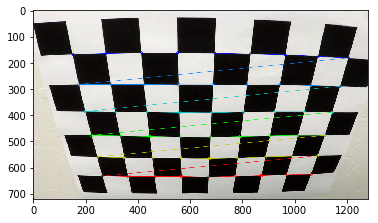

In [4]:
caname = 'camera_cal/calibration*.jpg'
objpoints, imgpoints, imgCBC = findpoints(caname)
plt.imshow(imgCBC)
plt.imsave("output_images/calibrationimgcbc.jpg", imgCBC)

define calibratecamera function to calculate ret,mtx,dist,rvecs values
and undistort function to undistort the image you want

In [5]:
def calibrateCamera(img,imgpoints,objpoints):
    pdistimg = np.copy(img)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, pdistimg.shape[1::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs
def undistort(img, ret, mtx, dist, rvecs, tvecs):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #plt.imsave("output_images/undistFtest1.jpg", undist)
    return undist 

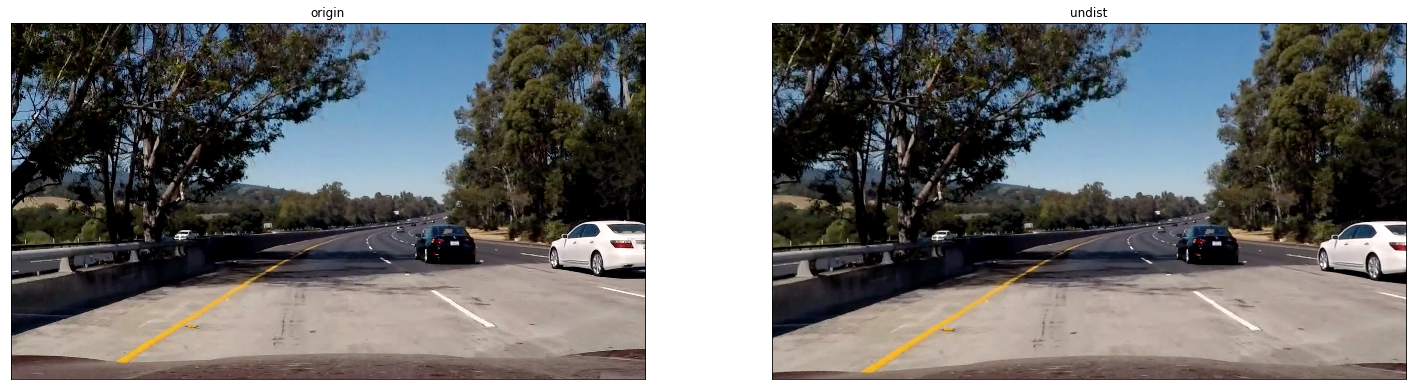

In [6]:
#undist the img
imgname = 'test_images/test5.jpg'
img = mpimg.imread(imgname)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size=(img.shape[1],img.shape[0])
ret, mtx, dist, rvecs, tvecs = calibrateCamera(img,imgpoints,objpoints)
undist = undistort(img,ret, mtx, dist, rvecs, tvecs)
showimg(img,"origin",undist,"undist")
plt.imsave("output_images/undist.jpg", undist)

define color and gradient function 
the gradient use sobel x method,magnitude method and direction method
the color use the s channel to splite lane lines

In [7]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

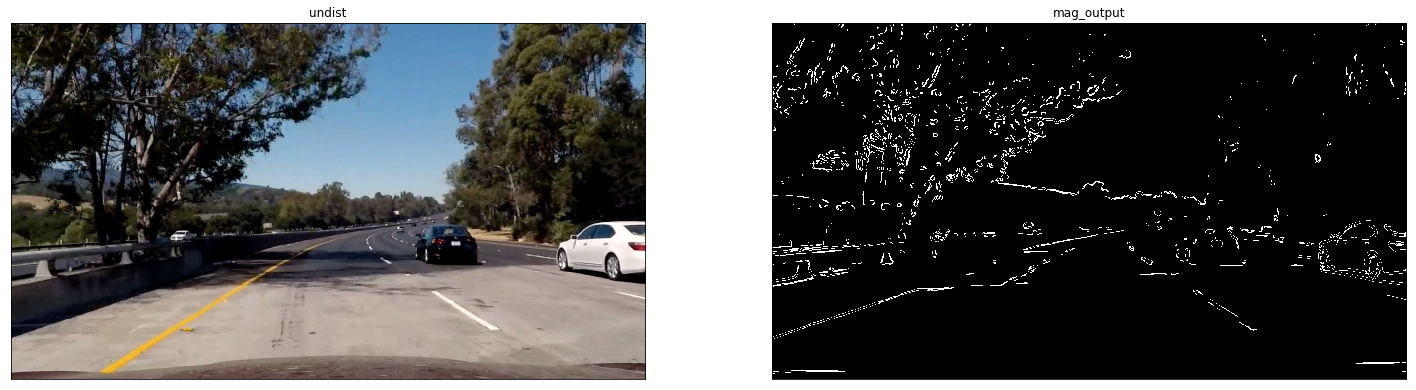

In [8]:
mag_output = mag_thresh(undist,sobel_kernel=15, mag_thresh=(70, 100))
showimg(undist,'undist',mag_output,'mag_output')
plt.imsave("output_images/mag_output.jpg", mag_output)

In [9]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    dg = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dg)
    binary_output[(dg >= thresh[0]) & (dg <=thresh[1])] = 1
    # 6) Return this mask as your binary_output image

    return binary_output


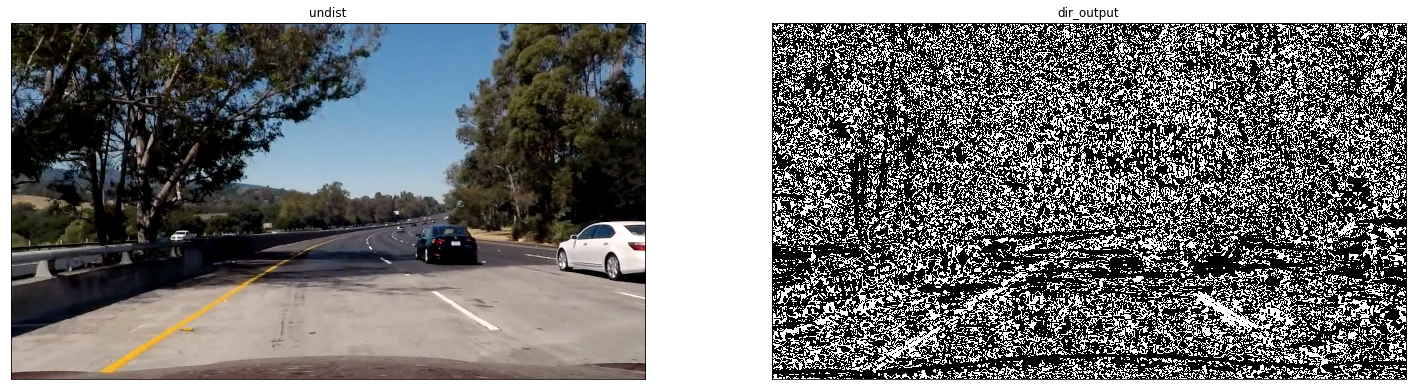

In [10]:
dir_output = dir_threshold(undist,sobel_kernel=15, thresh=(0.7, 1.3))
showimg(undist,'undist',dir_output,'dir_output')
plt.imsave("output_images/dir_output.jpg", dir_output)

In [11]:
def color_gradient(undist, sxy_thresh = (20, 100), s_thresh = (240, 255),sobel_kenerl = 3):
    cgimg = np.copy(undist)
    hls = cv2.cvtColor(cgimg, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    #gradient
    gray = cv2.cvtColor(cgimg,cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,sobel_kenerl))
    
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,sobel_kenerl))
    
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sxy_thresh[0]) & (scaled_sobelx <= sxy_thresh[1])] = 1
    #color
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= sxy_thresh[0]) & (scaled_sobely <= sxy_thresh[1])] = 1
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
   
    
    mag_binary = mag_thresh(undist,sobel_kernel=15, mag_thresh=(70, 100))
    dir_binary = dir_threshold(undist,sobel_kernel=15, thresh=(0.7, 1.3))
    combined_binary = np.zeros_like(mag_binary)
    combined_binary[(s_binary == 1)| ((sxbinary == 1) & (sybinary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #| ((sxbinary == 1) & (sybinary == 1))
    #| ((mag_binary == 1) & (dir_binary == 1))
    #plt.imshow(combined_binary,cmap='gray')
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    #min_sz = 50
    #cleaned = morphology.remove_small_objects(combined_binary.astype('bool'),min_size=min_sz,connectivity=2)
    #plt.imsave("output_images/combined_binary1.jpg", combined_binary)
    return combined_binary

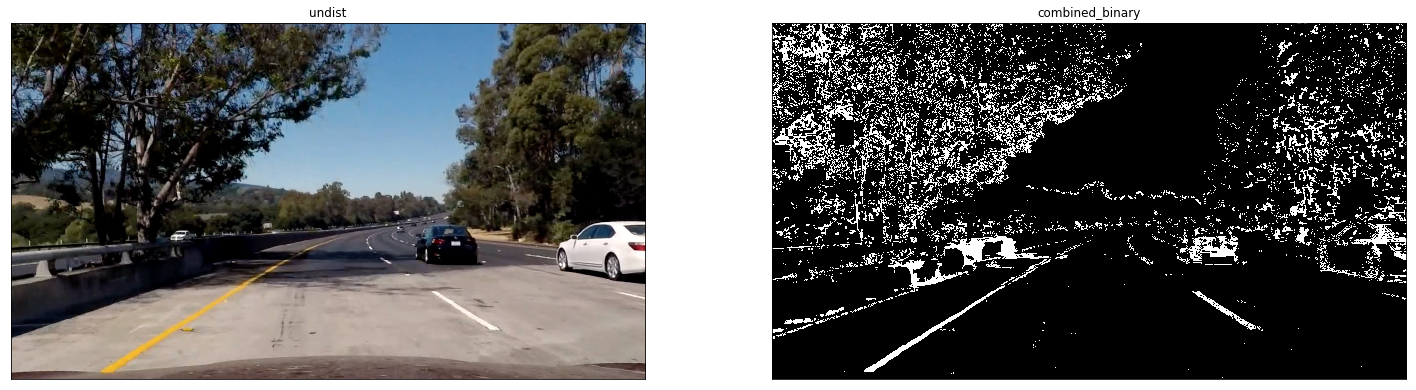

In [12]:
combined_binary = color_gradient(undist, sxy_thresh = (20, 100), s_thresh = (170, 255),sobel_kenerl = 15)
showimg(undist,"undist",combined_binary,"combined_binary")
plt.imsave("output_images/combined_binary.jpg", combined_binary)

prespective transform that transform the picture to bird view style

In [27]:
def warp(combined_binary):
    combined_binary_size = (combined_binary.shape[1], combined_binary.shape[0])

    
    undistgray = combined_binary.copy() #cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
        
    src = np.float32([[585, 460],[203, 720],[1127, 720],[695, 460]])

    dst = np.float32([[320, 0 ], [320, 720],[960, 720],[ 960, 0]])
    
#     #src = np.float32(
#             [[280,  700],  # Bottom left
#              [595,  460],  # Top left
#              [725,  460],  # Top right
#              [1125, 700]]) # Bottom right
    
#     #dst = dst_coordinates = np.float32(
#             [[250,  720],  # Bottom left
#              [250,    0],  # Top left
#              [1065,   0],  # Top right
#              [1065, 720]]) # Bottom right 
    
    #src = np.float32([[725,457],[1041,655],[347,649],[588,465]])

    #dst = np.float32([[1000, 0], [1000, 680],[200, 680],[200, 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(combined_binary, M, combined_binary_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

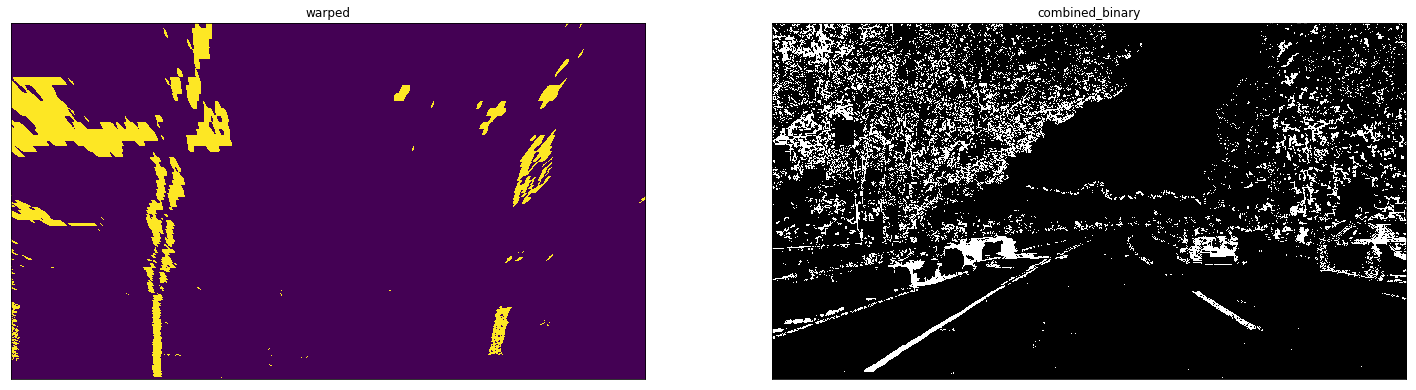

In [28]:
warped, M, Minv = warp(combined_binary)
showimg(warped,'warped',combined_binary,'combined_binary')
plt.imsave("output_images/warped.jpg", warped)

Next find the lane pixels and it's fit polynomial use windows

In [44]:
def hist(img):

    bottom_half = img[img.shape[0]//2:,:]

    histogram = np.sum(bottom_half,axis=0)
    plt.plot(histogram)
    return histogram

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = hist(binary_warped)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current-margin
        win_xleft_high = leftx_current+margin 
        win_xright_low = rightx_current-margin  
        win_xright_high = rightx_current+margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img 

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    for index in range(binary_warped.shape[0]):
        cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
        cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='pink')
    first = False

    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty

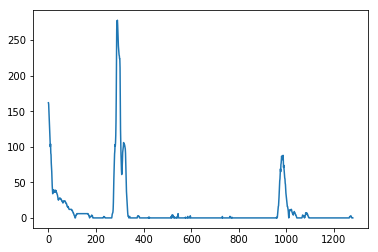

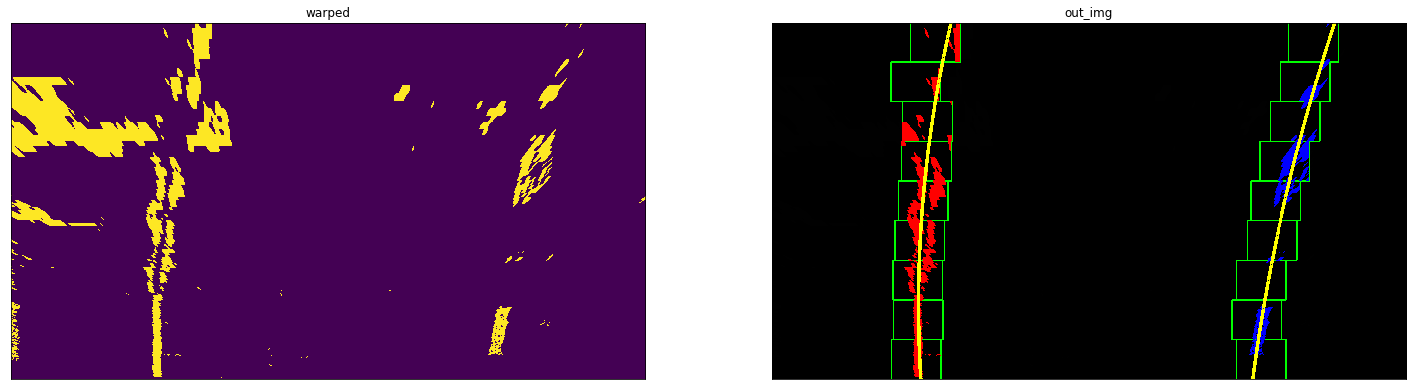

In [45]:
out_img, left_fit, right_fit, left_fitx, right_fitx, ploty= fit_polynomial(warped)
showimg(warped,'warped',out_img,'out_img')
plt.imsave("output_images/out_img.jpg", out_img)


after find the polynomial, we use the same values to search a similar one

In [47]:
def fit_poly2(img_shape, leftx, lefty, rightx, righty):
    ###  Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

def search_around_poly(binary_warped,left_fit=None,right_fit=None):
    
    if left_fit is None and right_fit is None:
        return fit_polynomial(binary_warped)
        
     
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 50

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    print(leftx.size,rightx.size)
    if (leftx.size == 0 or rightx.size == 0):
        return fit_polynomial(binary_warped)

    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly2(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    for index in range(binary_warped.shape[0]):
        cv2.circle(result, (int(left_fitx[index]), int(ploty[index])), 3, (255,255,0))
        cv2.circle(result, (int(right_fitx[index]), int(ploty[index])), 3, (255,255,0))
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fit, right_fit, left_fitx, right_fitx, ploty

17448 8572


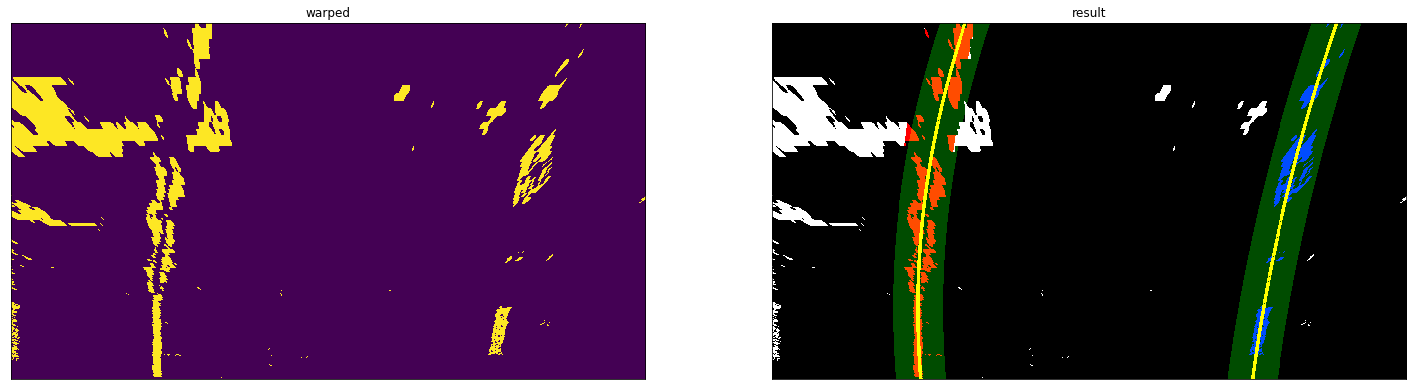

In [48]:
result,left_fit, right_fit,left_fitx,right_fitx , ploty= search_around_poly(warped,left_fit, right_fit)
showimg(warped,'warped',result,"result")
plt.imsave("output_images/result.jpg", result)

Then calculate the curvature of each lane line and calculate the car's situation

In [62]:
def measure_curvature_real(img_size,leftx,rightx):

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty = np.linspace(0, img_size[1] - 1, img_size[1])
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty*ym_per_pix)
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**(3/2))/(2*np.absolute(left_fit_cr[0]))  ## Implement the calculation of the left line here
    right_curverad = ((1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**(3/2))/(2*np.absolute(right_fit_cr[0]))  ## Implement the calculation of the right line here
    
    ## Image mid horizontal position 
    midx = img_size[0]//2 #img_size=(img.shape[1],img.shape[0])
        
    ## Car position with respect to the lane
    carx = (leftx[-1] + rightx[-1])/2
    #scale = 0.8
    #carx = carx*scale
#     print(carx)
#    print(midx)
#     print(midx-carx)
    ## Horizontal car offset 
    correction_tag=0.30
    
    offsetx = ((midx - carx) * xm_per_pix)
    offsetx = offsetx+correction_tag

    return left_curverad, right_curverad, offsetx

In [63]:
left_curverad, right_curverad,offsetx = measure_curvature_real(img_size,left_fitx,right_fitx)
print('left_curverad is', left_curverad,'m.','right_curverad is', right_curverad,'m')
print('car offset from center is', offsetx,'m.')

left_curverad is 737.673820578 m. right_curverad is 1482.03788697 m
car offset from center is -0.210550113559 m.


draw the lane one original image

In [64]:
def draw_lane(img, warped, left_fitx, right_fitx,ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    #print(pts)
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp,np.int_([pts_left]),False,(255,0,0),20)
    cv2.polylines(color_warp,np.int_([pts_right]),False,(0,0,255),20)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

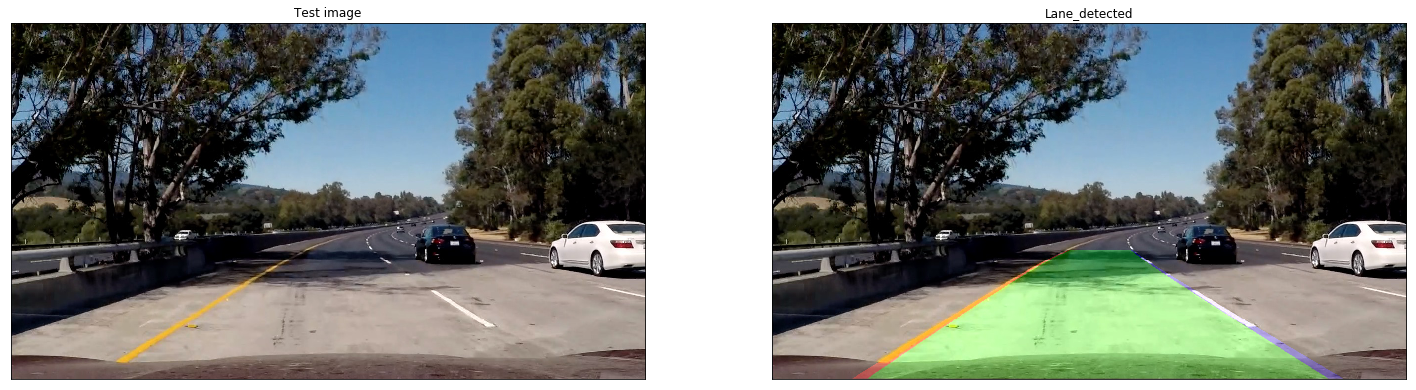

In [65]:

# Run the function
img_draw = draw_lane(img, warped, left_fitx, right_fitx, ploty,Minv)

# Plot the results
showimg(img, 'Test image', img_draw, 'Lane_detected')
plt.imsave("output_images/Lane_detected.jpg", img_draw)

add text informtion on the image

In [66]:
def add_text(img, left_curverad, right_curverad,offsetx):
    out_img = img.copy()
    cv2.putText(out_img, 'Left lane line curvature: {:.2f} m'.format(left_curverad), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'Right lane line curvature: {:.2f} m'.format(right_curverad), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'car offset from center: {:.2f} m'.format(offsetx), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    return out_img
    

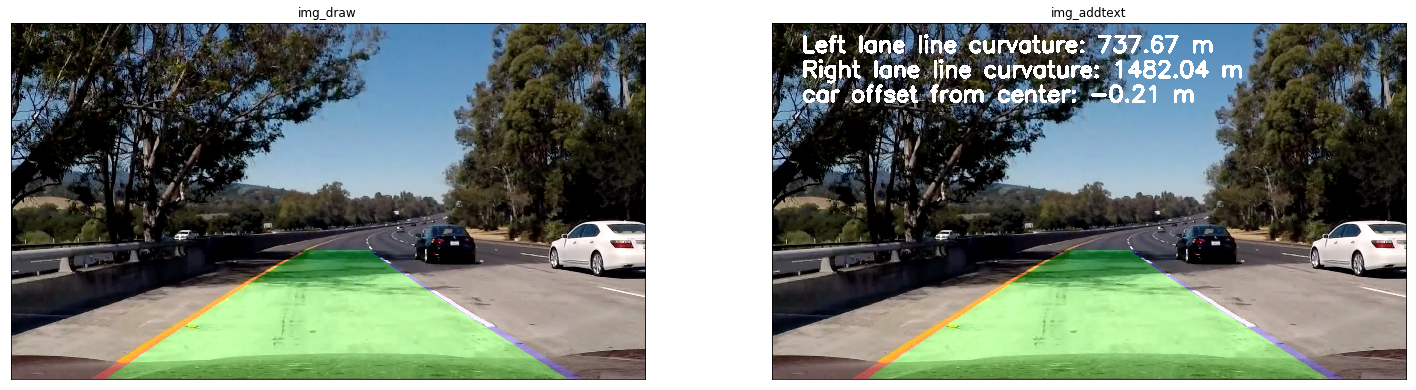

In [67]:
img_addtext = add_text(img_draw, left_curverad, right_curverad,offsetx)
showimg(img_draw,'img_draw',img_addtext,'img_addtext')
plt.imsave("output_images/img_addtext.jpg", img_addtext)

Now let's make a pipline to find lane lines on video.
call the function before just like calculate video on each frame

In [68]:
class PiplineProcess:
    def __init__(self,calimg):
        self.objpoints, self.imgpoints, self.imgCBC = findpoints(caname)
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = calibrateCamera(self.imgCBC,self.imgpoints,self.objpoints)
        self.left_fit = None
        self.right_fit = None
        
    def __call__(self,img):
        #set the img_size value
        img_size = (img.shape[1],img.shape[0])
        #use the calibrate values to undistort each image
        undist = undistort(img,self.ret, self.mtx, self.dist, self.rvecs, self.tvecs)
        #use color and gradient function to transform the
        combined_binary = color_gradient(undist, sxy_thresh = (30, 100), s_thresh = (170, 255),sobel_kenerl = 15)

        warped, M, Minv = warp(combined_binary)

        result,self.left_fit, self.right_fit, left_fitx, right_fitx , ploty= search_around_poly(warped,self.left_fit, self.right_fit)

        left_curverad, right_curverad, offsetx = measure_curvature_real(img_size,left_fitx,right_fitx)

        img_draw = draw_lane(img, warped, left_fitx, right_fitx, ploty,Minv)

        img_addtext = add_text(img_draw, left_curverad, right_curverad,offsetx)

        return img_addtext
        
        

        
    

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 1/1261 [00:00<06:08,  3.42it/s]

19214 5834


  0%|          | 2/1261 [00:00<06:21,  3.30it/s]

21337 6254


  0%|          | 3/1261 [00:00<06:18,  3.32it/s]

20423 6281


  0%|          | 4/1261 [00:01<06:14,  3.35it/s]

19385 5373


  0%|          | 5/1261 [00:01<06:12,  3.38it/s]

18648 7745


  0%|          | 6/1261 [00:01<06:08,  3.40it/s]

18364 6523


  1%|          | 7/1261 [00:02<06:07,  3.41it/s]

18671 5794


  1%|          | 8/1261 [00:02<06:07,  3.41it/s]

19857 6064


  1%|          | 9/1261 [00:02<06:07,  3.40it/s]

19014 6171


  1%|          | 10/1261 [00:02<06:08,  3.40it/s]

21715 5749


  1%|          | 11/1261 [00:03<06:07,  3.40it/s]

24998 5495


  1%|          | 12/1261 [00:03<06:06,  3.41it/s]

23282 5977


  1%|          | 13/1261 [00:03<06:05,  3.41it/s]

21558 6050


  1%|          | 14/1261 [00:04<06:04,  3.42it/s]

20346 6213


  1%|          | 15/1261 [00:04<06:05,  3.41it/s]

21181 5684


  1%|▏         | 16/1261 [00:04<06:07,  3.38it/s]

18563 5816


  1%|▏         | 17/1261 [00:05<06:06,  3.40it/s]

20653 7508


  1%|▏         | 18/1261 [00:05<06:05,  3.40it/s]

20029 8466


  2%|▏         | 19/1261 [00:05<06:05,  3.40it/s]

19383 7253


  2%|▏         | 20/1261 [00:05<06:03,  3.42it/s]

20689 6691


  2%|▏         | 21/1261 [00:06<06:02,  3.42it/s]

21850 5748


  2%|▏         | 22/1261 [00:06<06:00,  3.43it/s]

24895 5329


  2%|▏         | 23/1261 [00:06<06:00,  3.43it/s]

24471 5260


  2%|▏         | 24/1261 [00:07<06:02,  3.42it/s]

27392 5797


  2%|▏         | 25/1261 [00:07<05:58,  3.45it/s]

27326 6161


  2%|▏         | 26/1261 [00:07<05:56,  3.47it/s]

21428 5679


  2%|▏         | 27/1261 [00:07<05:55,  3.47it/s]

20305 6704


  2%|▏         | 28/1261 [00:08<05:56,  3.46it/s]

23176 6105


  2%|▏         | 29/1261 [00:08<05:57,  3.45it/s]

24401 5331


  2%|▏         | 30/1261 [00:08<05:59,  3.43it/s]

25818 5034


  2%|▏         | 31/1261 [00:09<05:59,  3.43it/s]

23693 6943


  3%|▎         | 32/1261 [00:09<05:58,  3.43it/s]

24821 6399


  3%|▎         | 33/1261 [00:09<05:57,  3.44it/s]

22283 6235


  3%|▎         | 34/1261 [00:09<05:55,  3.45it/s]

22521 6162


  3%|▎         | 35/1261 [00:10<05:54,  3.46it/s]

21829 6165


  3%|▎         | 36/1261 [00:10<05:56,  3.44it/s]

21209 5058


  3%|▎         | 37/1261 [00:10<05:55,  3.44it/s]

22482 5701


  3%|▎         | 38/1261 [00:11<05:55,  3.44it/s]

20986 5324


  3%|▎         | 39/1261 [00:11<05:55,  3.43it/s]

21701 5492


  3%|▎         | 40/1261 [00:11<05:55,  3.43it/s]

22351 6311


  3%|▎         | 41/1261 [00:12<05:55,  3.43it/s]

22048 7407


  3%|▎         | 42/1261 [00:12<05:54,  3.44it/s]

20597 7483


  3%|▎         | 43/1261 [00:12<07:40,  2.65it/s]

19569 6663


  3%|▎         | 44/1261 [00:13<07:35,  2.67it/s]

21481 5342


  4%|▎         | 45/1261 [00:13<07:38,  2.65it/s]

22090 5494


  4%|▎         | 46/1261 [00:13<07:37,  2.65it/s]

20527 4878


  4%|▎         | 47/1261 [00:14<07:40,  2.64it/s]

20350 5347


  4%|▍         | 48/1261 [00:14<07:28,  2.70it/s]

19878 6488


  4%|▍         | 49/1261 [00:15<07:34,  2.67it/s]

24344 5866


  4%|▍         | 50/1261 [00:15<07:26,  2.71it/s]

25040 6225


  4%|▍         | 51/1261 [00:15<07:32,  2.67it/s]

25760 5622


  4%|▍         | 52/1261 [00:16<07:22,  2.73it/s]

27791 5174


  4%|▍         | 53/1261 [00:16<07:33,  2.66it/s]

26812 5890


  4%|▍         | 54/1261 [00:16<07:24,  2.72it/s]

28253 5420


  4%|▍         | 55/1261 [00:17<07:32,  2.66it/s]

28111 5692


  4%|▍         | 56/1261 [00:17<07:22,  2.72it/s]

28528 6263


  5%|▍         | 57/1261 [00:18<07:39,  2.62it/s]

28544 6024


  5%|▍         | 58/1261 [00:18<07:28,  2.68it/s]

28030 5235


  5%|▍         | 59/1261 [00:18<07:37,  2.62it/s]

26080 4927


  5%|▍         | 60/1261 [00:19<07:29,  2.67it/s]

25351 5234


  5%|▍         | 61/1261 [00:19<07:38,  2.62it/s]

25823 6013


  5%|▍         | 62/1261 [00:19<07:27,  2.68it/s]

25824 5426


  5%|▍         | 63/1261 [00:20<07:35,  2.63it/s]

25479 5768


  5%|▌         | 64/1261 [00:20<07:24,  2.69it/s]

25424 5760


  5%|▌         | 65/1261 [00:21<07:31,  2.65it/s]

27171 5500


  5%|▌         | 66/1261 [00:21<07:20,  2.71it/s]

26540 6852


  5%|▌         | 67/1261 [00:21<07:30,  2.65it/s]

27797 6725


  5%|▌         | 68/1261 [00:22<07:19,  2.72it/s]

29208 7015


  5%|▌         | 69/1261 [00:22<07:27,  2.66it/s]

29034 6485


  6%|▌         | 70/1261 [00:22<07:18,  2.71it/s]

30477 5491


  6%|▌         | 71/1261 [00:23<07:27,  2.66it/s]

30276 5118


  6%|▌         | 72/1261 [00:23<07:19,  2.71it/s]

30884 4854


  6%|▌         | 73/1261 [00:24<07:29,  2.64it/s]

31436 5432


  6%|▌         | 74/1261 [00:24<07:21,  2.69it/s]

31304 5405


  6%|▌         | 75/1261 [00:24<07:28,  2.65it/s]

32125 5606


  6%|▌         | 76/1261 [00:25<07:18,  2.70it/s]

31524 5545


  6%|▌         | 77/1261 [00:25<07:25,  2.65it/s]

31920 5500


  6%|▌         | 78/1261 [00:25<07:15,  2.72it/s]

32934 5625


  6%|▋         | 79/1261 [00:26<07:22,  2.67it/s]

32996 6343


  6%|▋         | 80/1261 [00:26<07:11,  2.74it/s]

32096 6337


  6%|▋         | 81/1261 [00:27<07:14,  2.72it/s]

32336 6642


  7%|▋         | 82/1261 [00:27<07:19,  2.68it/s]

31982 6245


  7%|▋         | 83/1261 [00:27<07:10,  2.74it/s]

32192 5637


  7%|▋         | 84/1261 [00:28<07:16,  2.69it/s]

32326 5163


  7%|▋         | 85/1261 [00:28<07:08,  2.75it/s]

32826 5431


  7%|▋         | 86/1261 [00:28<07:14,  2.70it/s]

32010 5774


  7%|▋         | 87/1261 [00:29<07:22,  2.65it/s]

32087 5418


  7%|▋         | 88/1261 [00:29<07:13,  2.71it/s]

31093 5543


  7%|▋         | 89/1261 [00:30<07:20,  2.66it/s]

30510 5625


  7%|▋         | 90/1261 [00:30<07:16,  2.68it/s]

29561 5952


  7%|▋         | 91/1261 [00:30<07:24,  2.63it/s]

30808 7379


  7%|▋         | 92/1261 [00:31<07:14,  2.69it/s]

30469 6872


  7%|▋         | 93/1261 [00:31<07:22,  2.64it/s]

29560 7349


  7%|▋         | 94/1261 [00:31<07:11,  2.70it/s]

29804 7398


  8%|▊         | 95/1261 [00:32<07:18,  2.66it/s]

30206 5690


  8%|▊         | 96/1261 [00:32<07:08,  2.72it/s]

30200 6600


  8%|▊         | 97/1261 [00:32<07:09,  2.71it/s]

30650 6861


  8%|▊         | 98/1261 [00:33<07:11,  2.69it/s]

30344 6514


  8%|▊         | 99/1261 [00:33<07:04,  2.74it/s]

30427 6350


  8%|▊         | 100/1261 [00:34<07:12,  2.69it/s]

30068 5439


  8%|▊         | 101/1261 [00:34<07:04,  2.73it/s]

30654 5624


  8%|▊         | 102/1261 [00:34<07:17,  2.65it/s]

30125 5573


  8%|▊         | 103/1261 [00:35<07:09,  2.70it/s]

30215 6018


  8%|▊         | 104/1261 [00:35<07:16,  2.65it/s]

29734 5723


  8%|▊         | 105/1261 [00:35<07:07,  2.70it/s]

30091 5661


  8%|▊         | 106/1261 [00:36<07:16,  2.65it/s]

30016 6093


  8%|▊         | 107/1261 [00:36<07:06,  2.70it/s]

29854 6026


  9%|▊         | 108/1261 [00:37<07:14,  2.66it/s]

29254 6024


  9%|▊         | 109/1261 [00:37<07:05,  2.71it/s]

29411 6253


  9%|▊         | 110/1261 [00:37<07:11,  2.67it/s]

27334 5869


  9%|▉         | 111/1261 [00:38<07:01,  2.73it/s]

27966 6637


  9%|▉         | 112/1261 [00:38<07:11,  2.66it/s]

29016 6192


  9%|▉         | 113/1261 [00:38<07:04,  2.71it/s]

28583 5543


  9%|▉         | 114/1261 [00:39<07:13,  2.65it/s]

28278 5333


  9%|▉         | 115/1261 [00:39<07:03,  2.70it/s]

27422 5286


  9%|▉         | 116/1261 [00:40<07:11,  2.66it/s]

27849 6396


  9%|▉         | 117/1261 [00:40<07:02,  2.71it/s]

27739 6898


  9%|▉         | 118/1261 [00:40<07:11,  2.65it/s]

27119 6399


  9%|▉         | 119/1261 [00:41<07:02,  2.71it/s]

26867 6515


 10%|▉         | 120/1261 [00:41<07:12,  2.64it/s]

25954 7404


 10%|▉         | 121/1261 [00:41<07:02,  2.70it/s]

26484 6021


 10%|▉         | 122/1261 [00:42<07:09,  2.65it/s]

26247 6057


 10%|▉         | 123/1261 [00:42<06:57,  2.72it/s]

25917 6087


 10%|▉         | 124/1261 [00:43<07:01,  2.70it/s]

25700 5754


 10%|▉         | 125/1261 [00:43<06:50,  2.76it/s]

26829 5034


 10%|▉         | 126/1261 [00:43<06:55,  2.73it/s]

27252 4389


 10%|█         | 127/1261 [00:44<06:46,  2.79it/s]

26546 5476


 10%|█         | 128/1261 [00:44<06:54,  2.73it/s]

26532 5612


 10%|█         | 129/1261 [00:44<06:45,  2.79it/s]

25634 7158


 10%|█         | 130/1261 [00:45<06:52,  2.74it/s]

25569 6884


 10%|█         | 131/1261 [00:45<06:43,  2.80it/s]

25953 7882


 10%|█         | 132/1261 [00:45<06:53,  2.73it/s]

24593 9573


 11%|█         | 133/1261 [00:46<06:47,  2.77it/s]

24560 8490


 11%|█         | 134/1261 [00:46<06:51,  2.74it/s]

24982 7079


 11%|█         | 135/1261 [00:47<07:11,  2.61it/s]

24015 7022


 11%|█         | 136/1261 [00:47<06:56,  2.70it/s]

22895 6363


 11%|█         | 137/1261 [00:47<07:00,  2.67it/s]

25573 6459


 11%|█         | 138/1261 [00:48<06:46,  2.77it/s]

24812 7004


 11%|█         | 139/1261 [00:48<06:54,  2.71it/s]

24861 6589


 11%|█         | 140/1261 [00:48<06:45,  2.76it/s]

26891 6371


 11%|█         | 141/1261 [00:49<06:54,  2.70it/s]

26813 6117


 11%|█▏        | 142/1261 [00:49<06:47,  2.74it/s]

27647 6995


 11%|█▏        | 143/1261 [00:50<06:52,  2.71it/s]

27227 8275


 11%|█▏        | 144/1261 [00:50<06:43,  2.77it/s]

28348 7746


 11%|█▏        | 145/1261 [00:50<06:52,  2.71it/s]

27814 7643


 12%|█▏        | 146/1261 [00:51<06:48,  2.73it/s]

28240 8269


 12%|█▏        | 147/1261 [00:51<08:14,  2.25it/s]

28477 6848


 12%|█▏        | 148/1261 [00:52<08:32,  2.17it/s]

26761 6939


 12%|█▏        | 149/1261 [00:52<08:12,  2.26it/s]

26524 6285


 12%|█▏        | 150/1261 [00:52<07:44,  2.39it/s]

27014 6778


 12%|█▏        | 151/1261 [00:53<07:35,  2.44it/s]

28298 6091


 12%|█▏        | 152/1261 [00:53<07:14,  2.55it/s]

27665 6145


 12%|█▏        | 153/1261 [00:54<07:13,  2.55it/s]

28332 7229


 12%|█▏        | 154/1261 [00:54<06:59,  2.64it/s]

27892 7044


 12%|█▏        | 155/1261 [00:54<07:03,  2.61it/s]

29411 7551


 12%|█▏        | 156/1261 [00:55<06:51,  2.69it/s]

29113 7944


 12%|█▏        | 157/1261 [00:55<06:57,  2.64it/s]

29497 7872


 13%|█▎        | 158/1261 [00:55<06:45,  2.72it/s]

28537 8124


 13%|█▎        | 159/1261 [00:56<06:50,  2.68it/s]

27872 7821


 13%|█▎        | 160/1261 [00:56<06:43,  2.73it/s]

26814 7511


 13%|█▎        | 161/1261 [00:57<06:51,  2.67it/s]

28449 7090


 13%|█▎        | 162/1261 [00:57<06:45,  2.71it/s]

28187 6601


 13%|█▎        | 163/1261 [00:57<06:59,  2.62it/s]

28140 6799


 13%|█▎        | 164/1261 [00:58<06:50,  2.67it/s]

27731 5584


 13%|█▎        | 165/1261 [00:58<06:57,  2.63it/s]

28254 5128


 13%|█▎        | 166/1261 [00:58<06:52,  2.65it/s]

28197 7101


 13%|█▎        | 167/1261 [00:59<06:58,  2.62it/s]

27956 8298


 13%|█▎        | 168/1261 [00:59<06:49,  2.67it/s]

29352 6993


 13%|█▎        | 169/1261 [01:00<06:54,  2.63it/s]

30063 6835


 13%|█▎        | 170/1261 [01:00<06:47,  2.67it/s]

30387 6966


 14%|█▎        | 171/1261 [01:00<06:56,  2.62it/s]

29556 6874


 14%|█▎        | 172/1261 [01:01<06:47,  2.67it/s]

29516 7133


 14%|█▎        | 173/1261 [01:01<06:54,  2.63it/s]

29254 7234


 14%|█▍        | 174/1261 [01:01<06:45,  2.68it/s]

28628 5801


 14%|█▍        | 175/1261 [01:02<06:54,  2.62it/s]

27404 6316


 14%|█▍        | 176/1261 [01:02<06:45,  2.68it/s]

27622 5651


 14%|█▍        | 177/1261 [01:03<06:52,  2.63it/s]

27235 6079


 14%|█▍        | 178/1261 [01:03<06:44,  2.68it/s]

27891 7388


 14%|█▍        | 179/1261 [01:03<06:51,  2.63it/s]

27882 7690


 14%|█▍        | 180/1261 [01:04<06:42,  2.68it/s]

27985 7171


 14%|█▍        | 181/1261 [01:04<06:51,  2.63it/s]

28160 7931


 14%|█▍        | 182/1261 [01:04<06:40,  2.70it/s]

27737 7954


 15%|█▍        | 183/1261 [01:05<06:48,  2.64it/s]

27203 8806


 15%|█▍        | 184/1261 [01:05<06:37,  2.71it/s]

27297 5988


 15%|█▍        | 185/1261 [01:06<06:44,  2.66it/s]

26685 6609


 15%|█▍        | 186/1261 [01:06<06:35,  2.72it/s]

24089 5649


 15%|█▍        | 187/1261 [01:06<06:45,  2.65it/s]

24684 6253


 15%|█▍        | 188/1261 [01:07<06:34,  2.72it/s]

23894 6562


 15%|█▍        | 189/1261 [01:07<06:37,  2.69it/s]

23182 7397


 15%|█▌        | 190/1261 [01:07<06:30,  2.75it/s]

23255 9114


 15%|█▌        | 191/1261 [01:08<06:38,  2.68it/s]

23497 8453


 15%|█▌        | 192/1261 [01:08<06:30,  2.74it/s]

23074 9053


 15%|█▌        | 193/1261 [01:09<06:42,  2.65it/s]

23610 7364


 15%|█▌        | 194/1261 [01:09<06:34,  2.71it/s]

23234 7265


 15%|█▌        | 195/1261 [01:09<06:40,  2.66it/s]

24538 6072


 16%|█▌        | 196/1261 [01:10<06:31,  2.72it/s]

25342 5301


 16%|█▌        | 197/1261 [01:10<06:42,  2.64it/s]

27412 4943


 16%|█▌        | 198/1261 [01:10<06:33,  2.70it/s]

27459 5867


 16%|█▌        | 199/1261 [01:11<06:40,  2.65it/s]

29326 6050


 16%|█▌        | 200/1261 [01:11<06:32,  2.71it/s]

30311 5600


 16%|█▌        | 201/1261 [01:12<06:42,  2.63it/s]

30506 6070


 16%|█▌        | 202/1261 [01:12<06:32,  2.70it/s]

29884 6463


 16%|█▌        | 203/1261 [01:12<06:38,  2.65it/s]

29135 5853


 16%|█▌        | 204/1261 [01:13<06:27,  2.73it/s]

29495 5903


 16%|█▋        | 205/1261 [01:13<06:36,  2.66it/s]

28755 5975


 16%|█▋        | 206/1261 [01:13<06:27,  2.72it/s]

28549 7767


 16%|█▋        | 207/1261 [01:14<06:34,  2.67it/s]

27385 7222


 16%|█▋        | 208/1261 [01:14<06:27,  2.72it/s]

26380 6114


 17%|█▋        | 209/1261 [01:15<06:37,  2.65it/s]

27550 6112


 17%|█▋        | 210/1261 [01:15<06:31,  2.69it/s]

27743 7257


 17%|█▋        | 211/1261 [01:15<06:39,  2.63it/s]

28897 6163


 17%|█▋        | 212/1261 [01:16<06:28,  2.70it/s]

28175 6583


 17%|█▋        | 213/1261 [01:16<06:35,  2.65it/s]

27673 6408


 17%|█▋        | 214/1261 [01:16<06:24,  2.72it/s]

28013 6231


 17%|█▋        | 215/1261 [01:17<06:31,  2.67it/s]

27846 5668


 17%|█▋        | 216/1261 [01:17<06:23,  2.73it/s]

27588 7816


 17%|█▋        | 217/1261 [01:18<06:30,  2.67it/s]

27788 8755


 17%|█▋        | 218/1261 [01:18<06:23,  2.72it/s]

27948 7632


 17%|█▋        | 219/1261 [01:18<06:30,  2.67it/s]

28209 8913


 17%|█▋        | 220/1261 [01:19<06:23,  2.72it/s]

28828 7215


 18%|█▊        | 221/1261 [01:19<06:28,  2.67it/s]

29634 7419


 18%|█▊        | 222/1261 [01:19<06:21,  2.72it/s]

29120 7057


 18%|█▊        | 223/1261 [01:20<06:32,  2.64it/s]

29179 6432


 18%|█▊        | 224/1261 [01:20<06:26,  2.68it/s]

28663 6296


 18%|█▊        | 225/1261 [01:21<06:34,  2.62it/s]

28841 5841


 18%|█▊        | 226/1261 [01:21<06:25,  2.69it/s]

28974 5966


 18%|█▊        | 227/1261 [01:21<06:29,  2.65it/s]

29993 6348


 18%|█▊        | 228/1261 [01:22<06:19,  2.72it/s]

30826 7239


 18%|█▊        | 229/1261 [01:22<06:26,  2.67it/s]

30675 7578


 18%|█▊        | 230/1261 [01:22<06:19,  2.72it/s]

31649 7339


 18%|█▊        | 231/1261 [01:23<06:25,  2.67it/s]

31265 8176


 18%|█▊        | 232/1261 [01:23<06:16,  2.73it/s]

31310 7313


 18%|█▊        | 233/1261 [01:23<06:25,  2.67it/s]

31385 7743


 19%|█▊        | 234/1261 [01:24<06:16,  2.73it/s]

31415 7123


 19%|█▊        | 235/1261 [01:24<06:25,  2.66it/s]

31236 7389


 19%|█▊        | 236/1261 [01:25<06:16,  2.72it/s]

30564 6185


 19%|█▉        | 237/1261 [01:25<06:22,  2.67it/s]

31226 6262


 19%|█▉        | 238/1261 [01:25<06:12,  2.74it/s]

30822 5786


 19%|█▉        | 239/1261 [01:26<06:21,  2.68it/s]

30748 5904


 19%|█▉        | 240/1261 [01:26<06:13,  2.74it/s]

30364 7590


 19%|█▉        | 241/1261 [01:26<06:20,  2.68it/s]

30269 8235


 19%|█▉        | 242/1261 [01:27<06:12,  2.73it/s]

30929 7493


 19%|█▉        | 243/1261 [01:27<06:20,  2.68it/s]

30128 8909


 19%|█▉        | 244/1261 [01:28<06:12,  2.73it/s]

29748 8121


 19%|█▉        | 245/1261 [01:28<06:19,  2.68it/s]

30386 6748


 20%|█▉        | 246/1261 [01:28<06:10,  2.74it/s]

29979 6899


 20%|█▉        | 247/1261 [01:29<06:18,  2.68it/s]

30600 7472


 20%|█▉        | 248/1261 [01:29<06:10,  2.74it/s]

30273 5993


 20%|█▉        | 249/1261 [01:29<06:20,  2.66it/s]

31198 7023


 20%|█▉        | 250/1261 [01:30<06:11,  2.72it/s]

30484 7561


 20%|█▉        | 251/1261 [01:30<06:18,  2.67it/s]

30429 7563


 20%|█▉        | 252/1261 [01:30<06:12,  2.71it/s]

30338 7735


 20%|██        | 253/1261 [01:31<06:21,  2.64it/s]

30869 8612


 20%|██        | 254/1261 [01:31<06:14,  2.69it/s]

31155 8099


 20%|██        | 255/1261 [01:32<06:20,  2.65it/s]

30752 8439


 20%|██        | 256/1261 [01:32<06:08,  2.73it/s]

31094 8201


 20%|██        | 257/1261 [01:32<06:17,  2.66it/s]

30883 6931


 20%|██        | 258/1261 [01:33<06:08,  2.72it/s]

30169 7002


 21%|██        | 259/1261 [01:33<06:12,  2.69it/s]

30628 7201


 21%|██        | 260/1261 [01:33<06:05,  2.74it/s]

30420 5939


 21%|██        | 261/1261 [01:34<06:16,  2.66it/s]

31793 6297


 21%|██        | 262/1261 [01:34<06:08,  2.71it/s]

31236 6414


 21%|██        | 263/1261 [01:35<06:22,  2.61it/s]

32055 6651


 21%|██        | 264/1261 [01:35<06:12,  2.67it/s]

30961 7704


 21%|██        | 265/1261 [01:35<06:19,  2.63it/s]

31358 7860


 21%|██        | 266/1261 [01:36<06:12,  2.67it/s]

31440 7012


 21%|██        | 267/1261 [01:36<06:19,  2.62it/s]

31260 7665


 21%|██▏       | 268/1261 [01:36<06:11,  2.67it/s]

31483 8700


 21%|██▏       | 269/1261 [01:37<06:19,  2.62it/s]

31952 8022


 21%|██▏       | 270/1261 [01:37<06:13,  2.66it/s]

32315 8027


 21%|██▏       | 271/1261 [01:38<06:19,  2.61it/s]

32079 5835


 22%|██▏       | 272/1261 [01:38<06:09,  2.67it/s]

31669 6714


 22%|██▏       | 273/1261 [01:38<06:16,  2.63it/s]

31139 6606


 22%|██▏       | 274/1261 [01:39<06:07,  2.69it/s]

30840 6732


 22%|██▏       | 275/1261 [01:39<06:15,  2.63it/s]

30727 7940


 22%|██▏       | 276/1261 [01:40<06:05,  2.70it/s]

30364 7816


 22%|██▏       | 277/1261 [01:40<06:09,  2.66it/s]

30470 8072


 22%|██▏       | 278/1261 [01:40<06:01,  2.72it/s]

29992 8243


 22%|██▏       | 279/1261 [01:41<06:05,  2.68it/s]

30772 8331


 22%|██▏       | 280/1261 [01:41<05:57,  2.75it/s]

30908 8315


 22%|██▏       | 281/1261 [01:41<06:02,  2.70it/s]

30074 6122


 22%|██▏       | 282/1261 [01:42<05:54,  2.76it/s]

30150 6755


 22%|██▏       | 283/1261 [01:42<06:04,  2.69it/s]

30057 6333


 23%|██▎       | 284/1261 [01:42<05:54,  2.76it/s]

30718 5731


 23%|██▎       | 285/1261 [01:43<06:00,  2.71it/s]

31333 5532


 23%|██▎       | 286/1261 [01:43<05:51,  2.78it/s]

31506 5430


 23%|██▎       | 287/1261 [01:44<05:56,  2.73it/s]

31904 6017


 23%|██▎       | 288/1261 [01:44<05:47,  2.80it/s]

32372 6457


 23%|██▎       | 289/1261 [01:44<05:58,  2.71it/s]

32037 7883


 23%|██▎       | 290/1261 [01:45<05:53,  2.75it/s]

31983 6758


 23%|██▎       | 291/1261 [01:45<05:48,  2.79it/s]

31310 8587


 23%|██▎       | 292/1261 [01:45<05:48,  2.78it/s]

31411 8076


 23%|██▎       | 293/1261 [01:46<06:20,  2.54it/s]

31840 6114


 23%|██▎       | 294/1261 [01:46<06:09,  2.62it/s]

32520 6876


 23%|██▎       | 295/1261 [01:46<05:52,  2.74it/s]

32765 6154


 23%|██▎       | 296/1261 [01:47<05:53,  2.73it/s]

32961 5830


 24%|██▎       | 297/1261 [01:47<05:47,  2.78it/s]

33060 6084


 24%|██▎       | 298/1261 [01:48<05:52,  2.73it/s]

33139 6228


 24%|██▎       | 299/1261 [01:48<05:45,  2.78it/s]

33132 6324


 24%|██▍       | 300/1261 [01:48<05:57,  2.69it/s]

33484 7167


 24%|██▍       | 301/1261 [01:49<05:48,  2.75it/s]

33447 7430


 24%|██▍       | 302/1261 [01:49<05:56,  2.69it/s]

33559 7148


 24%|██▍       | 303/1261 [01:49<05:49,  2.74it/s]

33465 7004


 24%|██▍       | 304/1261 [01:50<05:55,  2.69it/s]

33785 6759


 24%|██▍       | 305/1261 [01:50<05:46,  2.76it/s]

34087 7367


 24%|██▍       | 306/1261 [01:51<05:53,  2.70it/s]

33537 6773


 24%|██▍       | 307/1261 [01:51<05:46,  2.75it/s]

34311 6756


 24%|██▍       | 308/1261 [01:51<05:53,  2.70it/s]

33875 6376


 25%|██▍       | 309/1261 [01:52<05:45,  2.76it/s]

34037 5684


 25%|██▍       | 310/1261 [01:52<05:52,  2.70it/s]

33983 5732


 25%|██▍       | 311/1261 [01:52<05:46,  2.74it/s]

33453 6573


 25%|██▍       | 312/1261 [01:53<05:56,  2.66it/s]

33847 7498


 25%|██▍       | 313/1261 [01:53<05:49,  2.72it/s]

32756 9330


 25%|██▍       | 314/1261 [01:53<05:56,  2.66it/s]

32921 9186


 25%|██▍       | 315/1261 [01:54<05:49,  2.71it/s]

33195 7603


 25%|██▌       | 316/1261 [01:54<05:55,  2.66it/s]

33656 8103


 25%|██▌       | 317/1261 [01:55<05:48,  2.71it/s]

34236 5993


 25%|██▌       | 318/1261 [01:55<05:55,  2.65it/s]

33425 5668


 25%|██▌       | 319/1261 [01:55<05:45,  2.72it/s]

33225 6489


 25%|██▌       | 320/1261 [01:56<05:53,  2.66it/s]

32678 6098


 25%|██▌       | 321/1261 [01:56<05:47,  2.70it/s]

33263 6815


 26%|██▌       | 322/1261 [01:56<05:44,  2.73it/s]

33326 7169


 26%|██▌       | 323/1261 [01:57<05:53,  2.65it/s]

33200 7701


 26%|██▌       | 324/1261 [01:57<05:48,  2.69it/s]

33965 6574


 26%|██▌       | 325/1261 [01:58<05:43,  2.72it/s]

33812 6480


 26%|██▌       | 326/1261 [01:58<05:54,  2.64it/s]

33279 7153


 26%|██▌       | 327/1261 [01:58<05:48,  2.68it/s]

34611 7366


 26%|██▌       | 328/1261 [01:59<05:44,  2.71it/s]

34553 6795


 26%|██▌       | 329/1261 [01:59<05:50,  2.66it/s]

34869 7084


 26%|██▌       | 330/1261 [01:59<05:43,  2.71it/s]

33844 6582


 26%|██▌       | 331/1261 [02:00<05:50,  2.65it/s]

33489 6865


 26%|██▋       | 332/1261 [02:00<05:44,  2.70it/s]

32706 6745


 26%|██▋       | 333/1261 [02:01<05:52,  2.63it/s]

32512 6700


 26%|██▋       | 334/1261 [02:01<06:45,  2.29it/s]

33232 6662


 27%|██▋       | 335/1261 [02:02<07:36,  2.03it/s]

32754 6818


 27%|██▋       | 336/1261 [02:02<08:10,  1.89it/s]

33400 6070


 27%|██▋       | 337/1261 [02:03<07:32,  2.04it/s]

33315 6532


 27%|██▋       | 338/1261 [02:03<06:53,  2.23it/s]

33372 6931


 27%|██▋       | 339/1261 [02:04<06:42,  2.29it/s]

33271 6639


 27%|██▋       | 340/1261 [02:04<06:18,  2.43it/s]

32223 6033


 27%|██▋       | 341/1261 [02:04<06:15,  2.45it/s]

32979 6106


 27%|██▋       | 342/1261 [02:05<05:59,  2.56it/s]

31752 5089


 27%|██▋       | 343/1261 [02:05<06:02,  2.53it/s]

32477 5413


 27%|██▋       | 344/1261 [02:05<05:51,  2.61it/s]

32427 5415


 27%|██▋       | 345/1261 [02:06<05:53,  2.59it/s]

31786 5401


 27%|██▋       | 346/1261 [02:06<05:41,  2.68it/s]

33291 6314


 28%|██▊       | 347/1261 [02:07<05:49,  2.61it/s]

33025 6490


 28%|██▊       | 348/1261 [02:07<05:41,  2.67it/s]

33423 6239


 28%|██▊       | 349/1261 [02:07<05:34,  2.73it/s]

32943 6726


 28%|██▊       | 350/1261 [02:08<05:44,  2.65it/s]

33062 7415


 28%|██▊       | 351/1261 [02:08<05:37,  2.69it/s]

31741 6315


 28%|██▊       | 352/1261 [02:08<05:35,  2.71it/s]

32704 6736


 28%|██▊       | 353/1261 [02:09<05:45,  2.63it/s]

33001 6174


 28%|██▊       | 354/1261 [02:09<05:39,  2.67it/s]

32838 4931


 28%|██▊       | 355/1261 [02:09<05:34,  2.71it/s]

32266 6951


 28%|██▊       | 356/1261 [02:10<05:44,  2.63it/s]

31926 5746


 28%|██▊       | 357/1261 [02:10<05:38,  2.67it/s]

32352 5283


 28%|██▊       | 358/1261 [02:11<05:32,  2.72it/s]

31948 5913


 28%|██▊       | 359/1261 [02:11<05:41,  2.64it/s]

31485 6008


 29%|██▊       | 360/1261 [02:11<05:36,  2.68it/s]

31991 6990


 29%|██▊       | 361/1261 [02:12<05:43,  2.62it/s]

31973 7295


 29%|██▊       | 362/1261 [02:12<05:35,  2.68it/s]

30822 7112


 29%|██▉       | 363/1261 [02:13<05:41,  2.63it/s]

30940 7598


 29%|██▉       | 364/1261 [02:13<05:32,  2.70it/s]

30478 6440


 29%|██▉       | 365/1261 [02:13<05:39,  2.64it/s]

30944 6420


 29%|██▉       | 366/1261 [02:14<05:31,  2.70it/s]

31088 6810


 29%|██▉       | 367/1261 [02:14<05:36,  2.66it/s]

30384 6749


 29%|██▉       | 368/1261 [02:14<05:28,  2.72it/s]

30421 5880


 29%|██▉       | 369/1261 [02:15<05:34,  2.67it/s]

29771 5868


 29%|██▉       | 370/1261 [02:15<05:28,  2.72it/s]

30666 6636


 29%|██▉       | 371/1261 [02:16<05:33,  2.67it/s]

30314 6564


 30%|██▉       | 372/1261 [02:16<05:26,  2.72it/s]

30385 6962


 30%|██▉       | 373/1261 [02:16<05:38,  2.63it/s]

30513 6943


 30%|██▉       | 374/1261 [02:17<05:31,  2.68it/s]

30602 7564


 30%|██▉       | 375/1261 [02:17<05:36,  2.63it/s]

29577 7052


 30%|██▉       | 376/1261 [02:17<05:28,  2.69it/s]

29977 6132


 30%|██▉       | 377/1261 [02:18<05:35,  2.64it/s]

30702 5604


 30%|██▉       | 378/1261 [02:18<05:27,  2.70it/s]

30708 5554


 30%|███       | 379/1261 [02:19<05:34,  2.63it/s]

31324 5496


 30%|███       | 380/1261 [02:19<05:27,  2.69it/s]

31367 6045


 30%|███       | 381/1261 [02:19<05:34,  2.63it/s]

30205 5620


 30%|███       | 382/1261 [02:20<05:26,  2.69it/s]

31271 6086


 30%|███       | 383/1261 [02:20<05:33,  2.63it/s]

30850 6119


 30%|███       | 384/1261 [02:20<05:27,  2.68it/s]

31247 6909


 31%|███       | 385/1261 [02:21<05:34,  2.62it/s]

31420 6671


 31%|███       | 386/1261 [02:21<05:25,  2.69it/s]

31018 6855


 31%|███       | 387/1261 [02:22<05:31,  2.64it/s]

31831 7259


 31%|███       | 388/1261 [02:22<05:22,  2.70it/s]

32006 6571


 31%|███       | 389/1261 [02:22<05:30,  2.64it/s]

32731 6465


 31%|███       | 390/1261 [02:23<05:25,  2.68it/s]

32638 6434


 31%|███       | 391/1261 [02:23<05:33,  2.61it/s]

31407 6681


 31%|███       | 392/1261 [02:23<05:26,  2.66it/s]

32850 6663


 31%|███       | 393/1261 [02:24<05:30,  2.63it/s]

32238 6430


 31%|███       | 394/1261 [02:24<05:22,  2.69it/s]

31754 6297


 31%|███▏      | 395/1261 [02:25<05:27,  2.65it/s]

31968 6002


 31%|███▏      | 396/1261 [02:25<05:20,  2.70it/s]

31655 5679


 31%|███▏      | 397/1261 [02:25<05:26,  2.65it/s]

32283 6905


 32%|███▏      | 398/1261 [02:26<05:17,  2.72it/s]

32287 7354


 32%|███▏      | 399/1261 [02:26<05:18,  2.71it/s]

30349 5628


 32%|███▏      | 400/1261 [02:26<05:22,  2.67it/s]

29774 6316


 32%|███▏      | 401/1261 [02:27<05:15,  2.73it/s]

31460 6014


 32%|███▏      | 402/1261 [02:27<05:27,  2.62it/s]

30926 7119


 32%|███▏      | 403/1261 [02:27<05:18,  2.69it/s]

31597 7169


 32%|███▏      | 404/1261 [02:28<05:24,  2.64it/s]

30714 6731


 32%|███▏      | 405/1261 [02:28<05:17,  2.70it/s]

30643 6124


 32%|███▏      | 406/1261 [02:29<05:23,  2.64it/s]

31376 6692


 32%|███▏      | 407/1261 [02:29<05:17,  2.69it/s]

32031 7343


 32%|███▏      | 408/1261 [02:29<05:20,  2.66it/s]

32247 6489


 32%|███▏      | 409/1261 [02:30<05:23,  2.64it/s]

29970 5606


 33%|███▎      | 410/1261 [02:30<05:16,  2.69it/s]

32318 6649


 33%|███▎      | 411/1261 [02:31<05:21,  2.64it/s]

32403 6634


 33%|███▎      | 412/1261 [02:31<05:14,  2.70it/s]

30711 6104


 33%|███▎      | 413/1261 [02:31<05:22,  2.63it/s]

31346 6067


 33%|███▎      | 414/1261 [02:32<05:16,  2.68it/s]

32100 6250


 33%|███▎      | 415/1261 [02:32<05:23,  2.62it/s]

31503 5968


 33%|███▎      | 416/1261 [02:32<05:16,  2.67it/s]

31721 6471


 33%|███▎      | 417/1261 [02:33<05:21,  2.63it/s]

30525 5919


 33%|███▎      | 418/1261 [02:33<05:13,  2.69it/s]

31600 6685


 33%|███▎      | 419/1261 [02:34<05:20,  2.63it/s]

32789 6754


 33%|███▎      | 420/1261 [02:34<05:15,  2.66it/s]

32145 5689


 33%|███▎      | 421/1261 [02:34<05:23,  2.60it/s]

32260 6287


 33%|███▎      | 422/1261 [02:35<05:16,  2.65it/s]

30976 6607


 34%|███▎      | 423/1261 [02:35<05:24,  2.59it/s]

30176 6200


 34%|███▎      | 424/1261 [02:35<05:16,  2.65it/s]

30416 5504


 34%|███▎      | 425/1261 [02:36<05:21,  2.60it/s]

31626 5960


 34%|███▍      | 426/1261 [02:36<05:13,  2.66it/s]

33692 6721


 34%|███▍      | 427/1261 [02:37<05:17,  2.63it/s]

32018 6686


 34%|███▍      | 428/1261 [02:37<05:09,  2.69it/s]

32520 6162


 34%|███▍      | 429/1261 [02:37<05:18,  2.61it/s]

32910 5985


 34%|███▍      | 430/1261 [02:38<05:11,  2.67it/s]

31890 6148


 34%|███▍      | 431/1261 [02:38<05:17,  2.62it/s]

32142 5994


 34%|███▍      | 432/1261 [02:38<05:09,  2.68it/s]

32883 6041


 34%|███▍      | 433/1261 [02:39<05:19,  2.59it/s]

33209 5973


 34%|███▍      | 434/1261 [02:39<05:11,  2.65it/s]

33819 6004


 34%|███▍      | 435/1261 [02:40<05:18,  2.60it/s]

33751 6722


 35%|███▍      | 436/1261 [02:40<05:10,  2.66it/s]

33787 7015


 35%|███▍      | 437/1261 [02:40<05:14,  2.62it/s]

33676 5778


 35%|███▍      | 438/1261 [02:41<05:05,  2.70it/s]

33684 6433


 35%|███▍      | 439/1261 [02:41<05:11,  2.64it/s]

32187 5881


 35%|███▍      | 440/1261 [02:41<05:03,  2.71it/s]

32999 6130


 35%|███▍      | 441/1261 [02:42<05:09,  2.65it/s]

31743 5886


 35%|███▌      | 442/1261 [02:42<05:01,  2.71it/s]

32946 5934


 35%|███▌      | 443/1261 [02:43<05:06,  2.67it/s]

32754 6424


 35%|███▌      | 444/1261 [02:43<04:58,  2.74it/s]

32796 6187


 35%|███▌      | 445/1261 [02:43<05:01,  2.70it/s]

32798 6193


 35%|███▌      | 446/1261 [02:44<04:55,  2.76it/s]

31856 6673


 35%|███▌      | 447/1261 [02:44<05:01,  2.70it/s]

32739 6614


 36%|███▌      | 448/1261 [02:44<04:53,  2.77it/s]

33726 6071


 36%|███▌      | 449/1261 [02:45<04:59,  2.71it/s]

33054 6295


 36%|███▌      | 450/1261 [02:45<04:54,  2.76it/s]

32181 5818


 36%|███▌      | 451/1261 [02:46<04:58,  2.71it/s]

35062 6670


 36%|███▌      | 452/1261 [02:46<04:53,  2.76it/s]

34998 6672


 36%|███▌      | 453/1261 [02:46<04:59,  2.70it/s]

32554 6161


 36%|███▌      | 454/1261 [02:47<04:51,  2.77it/s]

33656 5736


 36%|███▌      | 455/1261 [02:47<04:56,  2.72it/s]

33946 6364


 36%|███▌      | 456/1261 [02:47<04:50,  2.77it/s]

33541 6734


 36%|███▌      | 457/1261 [02:48<04:58,  2.69it/s]

32771 6912


 36%|███▋      | 458/1261 [02:48<04:54,  2.73it/s]

34076 7159


 36%|███▋      | 459/1261 [02:48<04:58,  2.69it/s]

33567 7000


 36%|███▋      | 460/1261 [02:49<04:51,  2.75it/s]

33998 6557


 37%|███▋      | 461/1261 [02:49<04:57,  2.69it/s]

34529 6739


 37%|███▋      | 462/1261 [02:50<04:49,  2.76it/s]

34424 6228


 37%|███▋      | 463/1261 [02:50<04:59,  2.67it/s]

33945 6154


 37%|███▋      | 464/1261 [02:50<04:53,  2.72it/s]

33430 5784


 37%|███▋      | 465/1261 [02:51<05:00,  2.65it/s]

33628 6046


 37%|███▋      | 466/1261 [02:51<04:54,  2.70it/s]

34761 5646


 37%|███▋      | 467/1261 [02:51<04:58,  2.66it/s]

34968 6199


 37%|███▋      | 468/1261 [02:52<04:55,  2.68it/s]

34789 5954


 37%|███▋      | 469/1261 [02:52<05:02,  2.62it/s]

34691 6925


 37%|███▋      | 470/1261 [02:53<04:56,  2.67it/s]

35657 6397


 37%|███▋      | 471/1261 [02:53<05:02,  2.61it/s]

35468 7377


 37%|███▋      | 472/1261 [02:53<04:54,  2.67it/s]

34971 5921


 38%|███▊      | 473/1261 [02:54<04:59,  2.63it/s]

36120 6797


 38%|███▊      | 474/1261 [02:54<04:52,  2.69it/s]

36132 6058


 38%|███▊      | 475/1261 [02:54<04:58,  2.64it/s]

36996 6475


 38%|███▊      | 476/1261 [02:55<04:50,  2.70it/s]

35812 6083


 38%|███▊      | 477/1261 [02:55<04:56,  2.65it/s]

35846 5971


 38%|███▊      | 478/1261 [02:56<04:47,  2.72it/s]

37113 6025


 38%|███▊      | 479/1261 [02:56<04:54,  2.66it/s]

36759 6127


 38%|███▊      | 480/1261 [02:56<04:49,  2.69it/s]

37327 6088


 38%|███▊      | 481/1261 [02:57<04:55,  2.64it/s]

37066 6328


 38%|███▊      | 482/1261 [02:57<04:48,  2.70it/s]

37746 6304


 38%|███▊      | 483/1261 [02:57<04:55,  2.64it/s]

38186 6434


 38%|███▊      | 484/1261 [02:58<04:47,  2.70it/s]

36987 6366


 38%|███▊      | 485/1261 [02:58<04:54,  2.64it/s]

37886 6827


 39%|███▊      | 486/1261 [02:59<04:46,  2.70it/s]

37522 7676


 39%|███▊      | 487/1261 [02:59<04:54,  2.63it/s]

37654 7156


 39%|███▊      | 488/1261 [02:59<04:49,  2.67it/s]

37163 6183


 39%|███▉      | 489/1261 [03:00<04:43,  2.72it/s]

33679 6015


 39%|███▉      | 490/1261 [03:00<04:51,  2.64it/s]

36623 6437


 39%|███▉      | 491/1261 [03:00<04:48,  2.67it/s]

34316 6038


 39%|███▉      | 492/1261 [03:01<04:43,  2.71it/s]

35129 6373


 39%|███▉      | 493/1261 [03:01<04:54,  2.60it/s]

35381 6787


 39%|███▉      | 494/1261 [03:02<04:48,  2.66it/s]

36327 6383


 39%|███▉      | 495/1261 [03:02<04:53,  2.61it/s]

36657 6505


 39%|███▉      | 496/1261 [03:02<04:45,  2.68it/s]

36966 6676


 39%|███▉      | 497/1261 [03:03<04:50,  2.63it/s]

37127 6258


 39%|███▉      | 498/1261 [03:03<04:42,  2.70it/s]

36500 6585


 40%|███▉      | 499/1261 [03:03<04:48,  2.64it/s]

36811 6612


 40%|███▉      | 500/1261 [03:04<04:40,  2.71it/s]

37508 6197


 40%|███▉      | 501/1261 [03:04<04:47,  2.64it/s]

37767 6318


 40%|███▉      | 502/1261 [03:05<04:41,  2.70it/s]

37212 6485


 40%|███▉      | 503/1261 [03:05<04:49,  2.62it/s]

37356 7012


 40%|███▉      | 504/1261 [03:05<04:45,  2.65it/s]

37105 6317


 40%|████      | 505/1261 [03:06<04:41,  2.69it/s]

37364 7138


 40%|████      | 506/1261 [03:06<04:50,  2.60it/s]

37339 6252


 40%|████      | 507/1261 [03:06<04:44,  2.65it/s]

37245 5541


 40%|████      | 508/1261 [03:07<04:39,  2.70it/s]

37886 6412


 40%|████      | 509/1261 [03:07<04:44,  2.64it/s]

37008 6206


 40%|████      | 510/1261 [03:08<04:39,  2.68it/s]

36589 6529


 41%|████      | 511/1261 [03:08<04:44,  2.63it/s]

36484 7111


 41%|████      | 512/1261 [03:08<04:38,  2.69it/s]

36643 7346


 41%|████      | 513/1261 [03:09<04:44,  2.63it/s]

34379 6594


 41%|████      | 514/1261 [03:09<04:37,  2.69it/s]

33553 6418


 41%|████      | 515/1261 [03:09<04:45,  2.61it/s]

31572 6274


 41%|████      | 516/1261 [03:10<04:41,  2.64it/s]

27913 6154


 41%|████      | 517/1261 [03:10<04:39,  2.67it/s]

30104 6790


 41%|████      | 518/1261 [03:11<04:46,  2.60it/s]

28355 5565


 41%|████      | 519/1261 [03:11<05:33,  2.22it/s]

27251 6134


 41%|████      | 520/1261 [03:12<06:24,  1.93it/s]

26136 5777


 41%|████▏     | 521/1261 [03:12<06:33,  1.88it/s]

25270 5991


 41%|████▏     | 522/1261 [03:13<06:57,  1.77it/s]

24535 6374


 41%|████▏     | 523/1261 [03:13<06:10,  1.99it/s]

26090 6733


 42%|████▏     | 524/1261 [03:14<05:47,  2.12it/s]

24480 7299


 42%|████▏     | 525/1261 [03:14<05:19,  2.30it/s]

24404 5996


 42%|████▏     | 526/1261 [03:15<05:11,  2.36it/s]

24839 7206


 42%|████▏     | 527/1261 [03:15<04:56,  2.48it/s]

25019 6949


 42%|████▏     | 528/1261 [03:15<04:55,  2.48it/s]

24950 7930


 42%|████▏     | 529/1261 [03:16<04:43,  2.58it/s]

23385 7931


 42%|████▏     | 530/1261 [03:16<04:45,  2.56it/s]

23151 9106


 42%|████▏     | 531/1261 [03:16<04:36,  2.64it/s]

21557 8451


 42%|████▏     | 532/1261 [03:17<04:40,  2.60it/s]

19523 6398


 42%|████▏     | 533/1261 [03:17<04:33,  2.66it/s]

18023 6335


 42%|████▏     | 534/1261 [03:18<04:37,  2.62it/s]

17300 5626


 42%|████▏     | 535/1261 [03:18<04:31,  2.67it/s]

17160 5805


 43%|████▎     | 536/1261 [03:18<04:37,  2.62it/s]

15714 6109


 43%|████▎     | 537/1261 [03:19<04:30,  2.67it/s]

14273 5896


 43%|████▎     | 538/1261 [03:19<04:35,  2.63it/s]

14692 6419


 43%|████▎     | 539/1261 [03:19<04:28,  2.69it/s]

13651 8439


 43%|████▎     | 540/1261 [03:20<04:35,  2.62it/s]

13456 9762


 43%|████▎     | 541/1261 [03:20<04:27,  2.69it/s]

14298 10144


 43%|████▎     | 542/1261 [03:21<04:27,  2.69it/s]

12093 8898


 43%|████▎     | 543/1261 [03:21<04:23,  2.72it/s]

11193 8700


 43%|████▎     | 544/1261 [03:21<04:20,  2.75it/s]

10522 7334


 43%|████▎     | 545/1261 [03:22<04:14,  2.81it/s]

11100 6816


 43%|████▎     | 546/1261 [03:22<04:21,  2.73it/s]

10237 6549


 43%|████▎     | 547/1261 [03:22<04:18,  2.76it/s]

11024 6152


 43%|████▎     | 548/1261 [03:23<04:27,  2.66it/s]

10385 6133


 44%|████▎     | 549/1261 [03:23<04:24,  2.69it/s]

11371 5988


 44%|████▎     | 550/1261 [03:24<04:30,  2.63it/s]

10646 6165


 44%|████▎     | 551/1261 [03:24<04:25,  2.68it/s]

11387 5720


 44%|████▍     | 552/1261 [03:24<04:37,  2.56it/s]

10998 6109


 44%|████▍     | 553/1261 [03:25<04:29,  2.63it/s]

10594 7272


 44%|████▍     | 554/1261 [03:25<04:37,  2.55it/s]

9014 7889


 44%|████▍     | 555/1261 [03:25<04:28,  2.63it/s]

8106 8954


 44%|████▍     | 556/1261 [03:26<04:34,  2.57it/s]

7265 8553


 44%|████▍     | 557/1261 [03:26<04:28,  2.63it/s]

6327 7726


 44%|████▍     | 558/1261 [03:27<04:36,  2.55it/s]

7214 7279


 44%|████▍     | 559/1261 [03:27<04:29,  2.60it/s]

7612 7988


 44%|████▍     | 560/1261 [03:27<04:35,  2.54it/s]

8398 8123


 44%|████▍     | 561/1261 [03:28<04:30,  2.59it/s]

9548 10590


 45%|████▍     | 562/1261 [03:28<04:49,  2.41it/s]

9399 10605


 45%|████▍     | 563/1261 [03:29<04:38,  2.51it/s]

7326 6617


 45%|████▍     | 564/1261 [03:29<04:40,  2.48it/s]

5783 4488


 45%|████▍     | 565/1261 [03:29<04:32,  2.56it/s]

5071 3836


 45%|████▍     | 566/1261 [03:30<04:36,  2.52it/s]

3984 4629


 45%|████▍     | 567/1261 [03:30<04:29,  2.57it/s]

4544 6247


 45%|████▌     | 568/1261 [03:31<04:35,  2.52it/s]

4070 6162


 45%|████▌     | 569/1261 [03:31<04:28,  2.58it/s]

4203 7066


 45%|████▌     | 570/1261 [03:31<04:34,  2.51it/s]

4096 6582


 45%|████▌     | 571/1261 [03:32<04:28,  2.57it/s]

5321 5560


 45%|████▌     | 572/1261 [03:32<04:32,  2.53it/s]

4553 5459


 45%|████▌     | 573/1261 [03:33<04:24,  2.60it/s]

4194 5048


 46%|████▌     | 574/1261 [03:33<04:27,  2.56it/s]

4002 4485


 46%|████▌     | 575/1261 [03:33<04:23,  2.61it/s]

3779 3881


 46%|████▌     | 576/1261 [03:34<04:27,  2.56it/s]

3334 5426


 46%|████▌     | 577/1261 [03:34<04:21,  2.61it/s]

3117 5624


 46%|████▌     | 578/1261 [03:35<04:27,  2.55it/s]

2984 5482


 46%|████▌     | 579/1261 [03:35<04:22,  2.60it/s]

3249 5106


 46%|████▌     | 580/1261 [03:35<04:26,  2.55it/s]

3005 5705


 46%|████▌     | 581/1261 [03:36<04:21,  2.60it/s]

2873 6185


 46%|████▌     | 582/1261 [03:36<04:31,  2.50it/s]

2851 6024


 46%|████▌     | 583/1261 [03:36<04:26,  2.55it/s]

2481 4964


 46%|████▋     | 584/1261 [03:37<04:28,  2.52it/s]

2528 4460


 46%|████▋     | 585/1261 [03:37<04:20,  2.60it/s]

2105 4696


 46%|████▋     | 586/1261 [03:38<04:25,  2.54it/s]

1942 5775


 47%|████▋     | 587/1261 [03:38<04:18,  2.61it/s]

1915 6275


 47%|████▋     | 588/1261 [03:38<04:22,  2.57it/s]

1956 6586


 47%|████▋     | 589/1261 [03:39<04:14,  2.64it/s]

2288 6681


 47%|████▋     | 590/1261 [03:39<04:14,  2.63it/s]

2373 5446


 47%|████▋     | 591/1261 [03:40<04:12,  2.65it/s]

2512 5548


 47%|████▋     | 592/1261 [03:40<04:10,  2.67it/s]

2547 5873


 47%|████▋     | 593/1261 [03:40<04:12,  2.64it/s]

2572 5538


 47%|████▋     | 594/1261 [03:41<04:12,  2.64it/s]

2515 5834


 47%|████▋     | 595/1261 [03:41<04:12,  2.64it/s]

2491 5663


 47%|████▋     | 596/1261 [03:41<04:11,  2.64it/s]

2342 5498


 47%|████▋     | 597/1261 [03:42<04:17,  2.58it/s]

2496 3853


 47%|████▋     | 598/1261 [03:42<04:10,  2.65it/s]

2716 3882


 48%|████▊     | 599/1261 [03:43<04:11,  2.63it/s]

2774 4322


 48%|████▊     | 600/1261 [03:43<04:11,  2.63it/s]

3212 3452


 48%|████▊     | 601/1261 [03:43<04:14,  2.59it/s]

5578 2836


 48%|████▊     | 602/1261 [03:44<04:07,  2.66it/s]

5050 3035


 48%|████▊     | 603/1261 [03:44<04:08,  2.65it/s]

7106 2914


 48%|████▊     | 604/1261 [03:44<04:06,  2.66it/s]

9181 2717


 48%|████▊     | 605/1261 [03:45<04:15,  2.56it/s]

9117 3701


 48%|████▊     | 606/1261 [03:45<04:08,  2.63it/s]

10318 4564


 48%|████▊     | 607/1261 [03:46<04:17,  2.54it/s]

12125 4171


 48%|████▊     | 608/1261 [03:46<04:10,  2.60it/s]

15859 4944


 48%|████▊     | 609/1261 [03:46<04:15,  2.56it/s]

17199 4221


 48%|████▊     | 610/1261 [03:47<04:07,  2.64it/s]

17676 4513


 48%|████▊     | 611/1261 [03:47<04:10,  2.59it/s]

18391 4328


 49%|████▊     | 612/1261 [03:48<04:04,  2.65it/s]

16848 3593


 49%|████▊     | 613/1261 [03:48<04:14,  2.55it/s]

21167 4038


 49%|████▊     | 614/1261 [03:48<04:07,  2.61it/s]

22492 4108


 49%|████▉     | 615/1261 [03:49<04:16,  2.52it/s]

23725 4761


 49%|████▉     | 616/1261 [03:49<04:09,  2.58it/s]

22087 4729


 49%|████▉     | 617/1261 [03:50<04:12,  2.55it/s]

24055 4464


 49%|████▉     | 618/1261 [03:50<04:04,  2.63it/s]

22998 4279


 49%|████▉     | 619/1261 [03:50<04:08,  2.58it/s]

21973 3928


 49%|████▉     | 620/1261 [03:51<04:03,  2.63it/s]

26998 4065


 49%|████▉     | 621/1261 [03:51<04:12,  2.53it/s]

28992 4600


 49%|████▉     | 622/1261 [03:51<04:06,  2.59it/s]

30463 5219


 49%|████▉     | 623/1261 [03:52<04:14,  2.50it/s]

29633 4603


 49%|████▉     | 624/1261 [03:52<04:09,  2.56it/s]

30771 4967


 50%|████▉     | 625/1261 [03:53<04:18,  2.46it/s]

21519 4887


 50%|████▉     | 626/1261 [03:53<04:10,  2.53it/s]

25110 5310


 50%|████▉     | 627/1261 [03:53<04:14,  2.49it/s]

26475 5490


 50%|████▉     | 628/1261 [03:54<04:06,  2.57it/s]

28875 4355


 50%|████▉     | 629/1261 [03:54<04:09,  2.54it/s]

30714 4704


 50%|████▉     | 630/1261 [03:55<04:03,  2.60it/s]

27294 4494


 50%|█████     | 631/1261 [03:55<04:07,  2.54it/s]

28629 5454


 50%|█████     | 632/1261 [03:55<04:00,  2.62it/s]

30848 5641


 50%|█████     | 633/1261 [03:56<04:02,  2.59it/s]

33427 4951


 50%|█████     | 634/1261 [03:56<04:05,  2.55it/s]

35356 4419


 50%|█████     | 635/1261 [03:57<03:59,  2.61it/s]

29688 4196


 50%|█████     | 636/1261 [03:57<04:04,  2.56it/s]

26527 4516


 51%|█████     | 637/1261 [03:57<03:58,  2.61it/s]

25668 5454


 51%|█████     | 638/1261 [03:58<04:03,  2.55it/s]

31745 5094


 51%|█████     | 639/1261 [03:58<03:57,  2.62it/s]

33512 4642


 51%|█████     | 640/1261 [03:58<04:02,  2.57it/s]

31677 5474


 51%|█████     | 641/1261 [03:59<03:56,  2.63it/s]

30413 4726


 51%|█████     | 642/1261 [03:59<04:05,  2.52it/s]

33441 4388


 51%|█████     | 643/1261 [04:00<03:57,  2.60it/s]

36290 4836


 51%|█████     | 644/1261 [04:00<04:00,  2.56it/s]

35266 5254


 51%|█████     | 645/1261 [04:00<03:54,  2.63it/s]

35277 5040


 51%|█████     | 646/1261 [04:01<03:59,  2.57it/s]

35083 4712


 51%|█████▏    | 647/1261 [04:01<03:54,  2.62it/s]

34070 4518


 51%|█████▏    | 648/1261 [04:02<03:58,  2.57it/s]

35903 4942


 51%|█████▏    | 649/1261 [04:02<03:53,  2.62it/s]

35293 5177


 52%|█████▏    | 650/1261 [04:02<03:58,  2.57it/s]

34875 4614


 52%|█████▏    | 651/1261 [04:03<03:53,  2.62it/s]

35408 4935


 52%|█████▏    | 652/1261 [04:03<03:58,  2.56it/s]

33773 4509


 52%|█████▏    | 653/1261 [04:03<03:52,  2.62it/s]

33753 4834


 52%|█████▏    | 654/1261 [04:04<03:55,  2.57it/s]

33030 3982


 52%|█████▏    | 655/1261 [04:04<03:50,  2.62it/s]

34138 4306


 52%|█████▏    | 656/1261 [04:05<03:54,  2.58it/s]

34739 4507


 52%|█████▏    | 657/1261 [04:05<03:49,  2.63it/s]

34600 4590


 52%|█████▏    | 658/1261 [04:05<03:51,  2.61it/s]

34711 4746


 52%|█████▏    | 659/1261 [04:06<03:53,  2.58it/s]

34781 4724


 52%|█████▏    | 660/1261 [04:06<03:48,  2.63it/s]

35411 5337


 52%|█████▏    | 661/1261 [04:07<03:51,  2.59it/s]

35777 5578


 52%|█████▏    | 662/1261 [04:07<03:50,  2.59it/s]

36437 6111


 53%|█████▎    | 663/1261 [04:07<03:50,  2.60it/s]

35891 7319


 53%|█████▎    | 664/1261 [04:08<03:50,  2.59it/s]

34858 6393


 53%|█████▎    | 665/1261 [04:08<03:53,  2.55it/s]

34127 6138


 53%|█████▎    | 666/1261 [04:08<03:47,  2.61it/s]

32625 5591


 53%|█████▎    | 667/1261 [04:09<04:01,  2.46it/s]

33284 4927


 53%|█████▎    | 668/1261 [04:09<03:54,  2.53it/s]

34563 5433


 53%|█████▎    | 669/1261 [04:10<04:03,  2.43it/s]

35505 4925


 53%|█████▎    | 670/1261 [04:10<03:56,  2.50it/s]

35265 6227


 53%|█████▎    | 671/1261 [04:11<03:59,  2.47it/s]

34187 6307


 53%|█████▎    | 672/1261 [04:11<03:52,  2.54it/s]

34565 5525


 53%|█████▎    | 673/1261 [04:11<03:57,  2.47it/s]

34741 5174


 53%|█████▎    | 674/1261 [04:12<03:50,  2.54it/s]

35021 5601


 54%|█████▎    | 675/1261 [04:12<03:54,  2.50it/s]

33656 5701


 54%|█████▎    | 676/1261 [04:12<03:47,  2.57it/s]

33831 6334


 54%|█████▎    | 677/1261 [04:13<03:53,  2.50it/s]

33917 5719


 54%|█████▍    | 678/1261 [04:13<03:46,  2.57it/s]

34531 5632


 54%|█████▍    | 679/1261 [04:14<03:50,  2.53it/s]

32021 4775


 54%|█████▍    | 680/1261 [04:14<03:45,  2.58it/s]

32291 4779


 54%|█████▍    | 681/1261 [04:14<03:49,  2.52it/s]

32342 5355


 54%|█████▍    | 682/1261 [04:15<03:44,  2.58it/s]

33166 4861


 54%|█████▍    | 683/1261 [04:15<03:48,  2.53it/s]

31607 4658


 54%|█████▍    | 684/1261 [04:16<03:41,  2.60it/s]

33715 4962


 54%|█████▍    | 685/1261 [04:16<03:46,  2.54it/s]

34809 5698


 54%|█████▍    | 686/1261 [04:16<03:39,  2.61it/s]

34627 5920


 54%|█████▍    | 687/1261 [04:17<03:43,  2.56it/s]

34318 6172


 55%|█████▍    | 688/1261 [04:17<03:37,  2.64it/s]

33516 5744


 55%|█████▍    | 689/1261 [04:18<03:40,  2.59it/s]

33894 6112


 55%|█████▍    | 690/1261 [04:18<03:35,  2.65it/s]

35280 6136


 55%|█████▍    | 691/1261 [04:18<03:39,  2.60it/s]

34659 6624


 55%|█████▍    | 692/1261 [04:19<03:34,  2.66it/s]

33486 6074


 55%|█████▍    | 693/1261 [04:19<03:34,  2.65it/s]

34866 5390


 55%|█████▌    | 694/1261 [04:19<03:35,  2.63it/s]

34118 5187


 55%|█████▌    | 695/1261 [04:20<03:29,  2.70it/s]

33333 5004


 55%|█████▌    | 696/1261 [04:20<03:33,  2.64it/s]

32888 4554


 55%|█████▌    | 697/1261 [04:21<03:28,  2.70it/s]

33560 5497


 55%|█████▌    | 698/1261 [04:21<04:03,  2.31it/s]

33929 5566


 55%|█████▌    | 699/1261 [04:22<04:33,  2.05it/s]

32722 5074


 56%|█████▌    | 700/1261 [04:22<05:04,  1.84it/s]

32681 5855


 56%|█████▌    | 701/1261 [04:23<05:14,  1.78it/s]

31994 6815


 56%|█████▌    | 702/1261 [04:24<05:28,  1.70it/s]

33743 7108


 56%|█████▌    | 703/1261 [04:24<05:01,  1.85it/s]

33558 5617


 56%|█████▌    | 704/1261 [04:24<04:28,  2.07it/s]

34259 5613


 56%|█████▌    | 705/1261 [04:25<04:13,  2.20it/s]

33786 5277


 56%|█████▌    | 706/1261 [04:25<03:54,  2.37it/s]

32811 5159


 56%|█████▌    | 707/1261 [04:26<03:48,  2.43it/s]

32607 5745


 56%|█████▌    | 708/1261 [04:26<03:36,  2.55it/s]

33342 5263


 56%|█████▌    | 709/1261 [04:26<03:36,  2.54it/s]

32636 5500


 56%|█████▋    | 710/1261 [04:27<03:30,  2.62it/s]

33531 6153


 56%|█████▋    | 711/1261 [04:27<03:25,  2.67it/s]

32444 5653


 56%|█████▋    | 712/1261 [04:27<03:31,  2.59it/s]

33417 6487


 57%|█████▋    | 713/1261 [04:28<03:26,  2.65it/s]

34171 5971


 57%|█████▋    | 714/1261 [04:28<03:22,  2.70it/s]

32463 5508


 57%|█████▋    | 715/1261 [04:29<03:28,  2.62it/s]

31759 5302


 57%|█████▋    | 716/1261 [04:29<03:25,  2.66it/s]

33498 5217


 57%|█████▋    | 717/1261 [04:29<03:22,  2.69it/s]

31402 5180


 57%|█████▋    | 718/1261 [04:30<03:28,  2.60it/s]

34268 5399


 57%|█████▋    | 719/1261 [04:30<03:25,  2.64it/s]

33386 5246


 57%|█████▋    | 720/1261 [04:30<03:23,  2.66it/s]

33780 5156


 57%|█████▋    | 721/1261 [04:31<03:29,  2.57it/s]

34570 6186


 57%|█████▋    | 722/1261 [04:31<03:25,  2.62it/s]

34381 5982


 57%|█████▋    | 723/1261 [04:32<03:22,  2.66it/s]

35072 6426


 57%|█████▋    | 724/1261 [04:32<03:28,  2.58it/s]

34241 6297


 57%|█████▋    | 725/1261 [04:32<03:24,  2.63it/s]

34549 6467


 58%|█████▊    | 726/1261 [04:33<03:19,  2.68it/s]

33768 6976


 58%|█████▊    | 727/1261 [04:33<03:24,  2.61it/s]

34464 6287


 58%|█████▊    | 728/1261 [04:33<03:20,  2.65it/s]

34485 6675


 58%|█████▊    | 729/1261 [04:34<03:17,  2.69it/s]

34192 6321


 58%|█████▊    | 730/1261 [04:34<03:23,  2.61it/s]

34232 5887


 58%|█████▊    | 731/1261 [04:35<03:19,  2.66it/s]

33930 6016


 58%|█████▊    | 732/1261 [04:35<03:16,  2.70it/s]

33801 5767


 58%|█████▊    | 733/1261 [04:35<03:23,  2.59it/s]

34425 6535


 58%|█████▊    | 734/1261 [04:36<03:18,  2.65it/s]

33798 6617


 58%|█████▊    | 735/1261 [04:36<03:23,  2.58it/s]

33940 7149


 58%|█████▊    | 736/1261 [04:37<03:20,  2.62it/s]

33777 7026


 58%|█████▊    | 737/1261 [04:37<03:16,  2.67it/s]

34747 7092


 59%|█████▊    | 738/1261 [04:37<03:22,  2.58it/s]

33675 7288


 59%|█████▊    | 739/1261 [04:38<03:17,  2.64it/s]

33582 7259


 59%|█████▊    | 740/1261 [04:38<03:15,  2.67it/s]

33208 5728


 59%|█████▉    | 741/1261 [04:38<03:21,  2.58it/s]

33902 5825


 59%|█████▉    | 742/1261 [04:39<03:17,  2.63it/s]

33929 6035


 59%|█████▉    | 743/1261 [04:39<03:15,  2.66it/s]

33797 5361


 59%|█████▉    | 744/1261 [04:40<03:20,  2.58it/s]

34141 5851


 59%|█████▉    | 745/1261 [04:40<03:16,  2.62it/s]

33667 6071


 59%|█████▉    | 746/1261 [04:40<03:12,  2.68it/s]

34622 5785


 59%|█████▉    | 747/1261 [04:41<03:16,  2.62it/s]

34484 6060


 59%|█████▉    | 748/1261 [04:41<03:10,  2.69it/s]

34061 6177


 59%|█████▉    | 749/1261 [04:41<03:13,  2.64it/s]

33867 6768


 59%|█████▉    | 750/1261 [04:42<03:10,  2.69it/s]

33821 5964


 60%|█████▉    | 751/1261 [04:42<03:13,  2.64it/s]

34635 6246


 60%|█████▉    | 752/1261 [04:43<03:08,  2.70it/s]

33716 6474


 60%|█████▉    | 753/1261 [04:43<03:10,  2.67it/s]

34379 6322


 60%|█████▉    | 754/1261 [04:43<03:05,  2.74it/s]

33840 6284


 60%|█████▉    | 755/1261 [04:44<03:08,  2.68it/s]

34163 6162


 60%|█████▉    | 756/1261 [04:44<03:03,  2.75it/s]

33886 6128


 60%|██████    | 757/1261 [04:44<03:07,  2.69it/s]

33519 5759


 60%|██████    | 758/1261 [04:45<03:04,  2.73it/s]

33791 6286


 60%|██████    | 759/1261 [04:45<03:00,  2.77it/s]

34625 7006


 60%|██████    | 760/1261 [04:45<03:06,  2.69it/s]

34776 6268


 60%|██████    | 761/1261 [04:46<03:04,  2.71it/s]

34331 6331


 60%|██████    | 762/1261 [04:46<03:03,  2.72it/s]

34269 7058


 61%|██████    | 763/1261 [04:47<03:10,  2.61it/s]

33927 5911


 61%|██████    | 764/1261 [04:47<03:04,  2.69it/s]

34162 6034


 61%|██████    | 765/1261 [04:47<03:08,  2.64it/s]

34142 6865


 61%|██████    | 766/1261 [04:48<03:02,  2.71it/s]

34715 5898


 61%|██████    | 767/1261 [04:48<03:04,  2.68it/s]

34201 5924


 61%|██████    | 768/1261 [04:48<02:59,  2.75it/s]

34011 5921


 61%|██████    | 769/1261 [04:49<03:03,  2.68it/s]

33075 5394


 61%|██████    | 770/1261 [04:49<02:59,  2.73it/s]

34200 6154


 61%|██████    | 771/1261 [04:50<03:03,  2.67it/s]

34484 6756


 61%|██████    | 772/1261 [04:50<03:00,  2.71it/s]

34838 6474


 61%|██████▏   | 773/1261 [04:50<02:57,  2.75it/s]

34378 6886


 61%|██████▏   | 774/1261 [04:51<03:03,  2.66it/s]

35149 7213


 61%|██████▏   | 775/1261 [04:51<02:59,  2.71it/s]

35047 6441


 62%|██████▏   | 776/1261 [04:51<03:02,  2.66it/s]

33940 5416


 62%|██████▏   | 777/1261 [04:52<02:58,  2.71it/s]

34603 6221


 62%|██████▏   | 778/1261 [04:52<02:55,  2.75it/s]

34097 6030


 62%|██████▏   | 779/1261 [04:53<03:01,  2.66it/s]

33368 6239


 62%|██████▏   | 780/1261 [04:53<02:58,  2.70it/s]

33725 5989


 62%|██████▏   | 781/1261 [04:53<03:04,  2.60it/s]

33571 5757


 62%|██████▏   | 782/1261 [04:54<03:00,  2.65it/s]

33364 6195


 62%|██████▏   | 783/1261 [04:54<02:58,  2.68it/s]

33922 6872


 62%|██████▏   | 784/1261 [04:54<03:02,  2.61it/s]

33260 6720


 62%|██████▏   | 785/1261 [04:55<02:57,  2.68it/s]

34346 7346


 62%|██████▏   | 786/1261 [04:55<03:01,  2.62it/s]

33510 6389


 62%|██████▏   | 787/1261 [04:56<02:56,  2.69it/s]

34397 7280


 62%|██████▏   | 788/1261 [04:56<02:59,  2.64it/s]

33881 6415


 63%|██████▎   | 789/1261 [04:56<02:56,  2.68it/s]

33000 6251


 63%|██████▎   | 790/1261 [04:57<02:59,  2.62it/s]

34156 6256


 63%|██████▎   | 791/1261 [04:57<02:55,  2.68it/s]

33554 5730


 63%|██████▎   | 792/1261 [04:57<02:54,  2.69it/s]

34144 6051


 63%|██████▎   | 793/1261 [04:58<02:53,  2.70it/s]

33472 5676


 63%|██████▎   | 794/1261 [04:58<02:52,  2.71it/s]

33744 6629


 63%|██████▎   | 795/1261 [04:59<02:47,  2.78it/s]

33912 6904


 63%|██████▎   | 796/1261 [04:59<02:51,  2.71it/s]

32823 8338


 63%|██████▎   | 797/1261 [04:59<02:50,  2.73it/s]

33520 7407


 63%|██████▎   | 798/1261 [05:00<02:48,  2.74it/s]

32731 6066


 63%|██████▎   | 799/1261 [05:00<02:56,  2.61it/s]

32519 6551


 63%|██████▎   | 800/1261 [05:00<02:54,  2.64it/s]

32922 6192


 64%|██████▎   | 801/1261 [05:01<02:51,  2.68it/s]

32015 5614


 64%|██████▎   | 802/1261 [05:01<02:57,  2.59it/s]

33803 6694


 64%|██████▎   | 803/1261 [05:02<02:54,  2.63it/s]

33136 5993


 64%|██████▍   | 804/1261 [05:02<02:51,  2.66it/s]

33048 5644


 64%|██████▍   | 805/1261 [05:02<02:55,  2.60it/s]

32991 6201


 64%|██████▍   | 806/1261 [05:03<02:50,  2.66it/s]

32700 5990


 64%|██████▍   | 807/1261 [05:03<02:54,  2.60it/s]

33431 6796


 64%|██████▍   | 808/1261 [05:03<02:49,  2.66it/s]

33222 6648


 64%|██████▍   | 809/1261 [05:04<02:52,  2.61it/s]

34133 6785


 64%|██████▍   | 810/1261 [05:04<02:49,  2.66it/s]

33332 5821


 64%|██████▍   | 811/1261 [05:05<02:52,  2.61it/s]

32725 6077


 64%|██████▍   | 812/1261 [05:05<02:48,  2.67it/s]

33981 5900


 64%|██████▍   | 813/1261 [05:05<02:51,  2.61it/s]

33526 5913


 65%|██████▍   | 814/1261 [05:06<02:46,  2.69it/s]

34528 6270


 65%|██████▍   | 815/1261 [05:06<02:49,  2.64it/s]

34818 6247


 65%|██████▍   | 816/1261 [05:06<02:44,  2.70it/s]

34404 5873


 65%|██████▍   | 817/1261 [05:07<02:47,  2.65it/s]

33376 5427


 65%|██████▍   | 818/1261 [05:07<02:43,  2.70it/s]

34085 5750


 65%|██████▍   | 819/1261 [05:08<02:45,  2.66it/s]

33066 5652


 65%|██████▌   | 820/1261 [05:08<02:42,  2.71it/s]

33530 6918


 65%|██████▌   | 821/1261 [05:08<02:44,  2.67it/s]

32568 6341


 65%|██████▌   | 822/1261 [05:09<02:41,  2.71it/s]

33392 6447


 65%|██████▌   | 823/1261 [05:09<02:47,  2.62it/s]

34022 5954


 65%|██████▌   | 824/1261 [05:09<02:43,  2.67it/s]

34806 7139


 65%|██████▌   | 825/1261 [05:10<02:45,  2.63it/s]

35089 6849


 66%|██████▌   | 826/1261 [05:10<02:42,  2.68it/s]

35079 6662


 66%|██████▌   | 827/1261 [05:11<02:45,  2.62it/s]

34774 6881


 66%|██████▌   | 828/1261 [05:11<02:41,  2.68it/s]

34078 6396


 66%|██████▌   | 829/1261 [05:11<02:44,  2.62it/s]

34410 6127


 66%|██████▌   | 830/1261 [05:12<02:41,  2.67it/s]

34696 6235


 66%|██████▌   | 831/1261 [05:12<02:44,  2.62it/s]

34562 6765


 66%|██████▌   | 832/1261 [05:12<02:40,  2.67it/s]

34231 6301


 66%|██████▌   | 833/1261 [05:13<02:43,  2.62it/s]

33588 7338


 66%|██████▌   | 834/1261 [05:13<02:39,  2.67it/s]

33819 6236


 66%|██████▌   | 835/1261 [05:14<02:42,  2.63it/s]

34387 6779


 66%|██████▋   | 836/1261 [05:14<02:38,  2.68it/s]

34658 6953


 66%|██████▋   | 837/1261 [05:14<02:42,  2.61it/s]

34901 7467


 66%|██████▋   | 838/1261 [05:15<02:37,  2.68it/s]

34724 7172


 67%|██████▋   | 839/1261 [05:15<02:40,  2.62it/s]

35597 6888


 67%|██████▋   | 840/1261 [05:15<02:37,  2.67it/s]

35360 6528


 67%|██████▋   | 841/1261 [05:16<02:41,  2.61it/s]

36520 6816


 67%|██████▋   | 842/1261 [05:16<02:37,  2.67it/s]

35919 6541


 67%|██████▋   | 843/1261 [05:17<02:40,  2.61it/s]

35898 6408


 67%|██████▋   | 844/1261 [05:17<02:36,  2.67it/s]

36037 6096


 67%|██████▋   | 845/1261 [05:17<02:39,  2.61it/s]

37582 5707


 67%|██████▋   | 846/1261 [05:18<02:35,  2.67it/s]

36695 5577


 67%|██████▋   | 847/1261 [05:18<02:38,  2.61it/s]

37176 6539


 67%|██████▋   | 848/1261 [05:19<02:34,  2.67it/s]

36648 6491


 67%|██████▋   | 849/1261 [05:19<02:38,  2.61it/s]

37763 6974


 67%|██████▋   | 850/1261 [05:19<02:35,  2.64it/s]

36978 7399


 67%|██████▋   | 851/1261 [05:20<02:33,  2.68it/s]

37133 6834


 68%|██████▊   | 852/1261 [05:20<02:38,  2.57it/s]

37592 7217


 68%|██████▊   | 853/1261 [05:20<02:34,  2.64it/s]

35459 6735


 68%|██████▊   | 854/1261 [05:21<02:36,  2.60it/s]

34425 6719


 68%|██████▊   | 855/1261 [05:21<02:31,  2.67it/s]

37459 6289


 68%|██████▊   | 856/1261 [05:22<02:33,  2.63it/s]

37157 6131


 68%|██████▊   | 857/1261 [05:22<02:29,  2.70it/s]

36887 5026


 68%|██████▊   | 858/1261 [05:22<02:34,  2.61it/s]

34890 5180


 68%|██████▊   | 859/1261 [05:23<02:32,  2.64it/s]

36248 7160


 68%|██████▊   | 860/1261 [05:23<02:29,  2.67it/s]

36432 6905


 68%|██████▊   | 861/1261 [05:23<02:34,  2.59it/s]

35668 6546


 68%|██████▊   | 862/1261 [05:24<02:31,  2.64it/s]

36458 6742


 68%|██████▊   | 863/1261 [05:24<02:28,  2.68it/s]

34795 6204


 69%|██████▊   | 864/1261 [05:25<02:32,  2.60it/s]

36603 6346


 69%|██████▊   | 865/1261 [05:25<02:29,  2.65it/s]

36227 6752


 69%|██████▊   | 866/1261 [05:25<02:26,  2.70it/s]

34200 5991


 69%|██████▉   | 867/1261 [05:26<02:30,  2.61it/s]

34243 6219


 69%|██████▉   | 868/1261 [05:26<02:25,  2.69it/s]

35772 5150


 69%|██████▉   | 869/1261 [05:26<02:28,  2.65it/s]

37121 5561


 69%|██████▉   | 870/1261 [05:27<02:25,  2.69it/s]

36717 5283


 69%|██████▉   | 871/1261 [05:27<02:27,  2.65it/s]

37090 5931


 69%|██████▉   | 872/1261 [05:28<02:23,  2.70it/s]

37102 7137


 69%|██████▉   | 873/1261 [05:28<02:26,  2.66it/s]

37719 7621


 69%|██████▉   | 874/1261 [05:28<02:22,  2.71it/s]

36923 7325


 69%|██████▉   | 875/1261 [05:29<02:24,  2.67it/s]

38115 7540


 69%|██████▉   | 876/1261 [05:29<02:21,  2.73it/s]

37683 7154


 70%|██████▉   | 877/1261 [05:29<02:23,  2.67it/s]

36813 6348


 70%|██████▉   | 878/1261 [05:30<02:20,  2.72it/s]

37937 7115


 70%|██████▉   | 879/1261 [05:30<02:23,  2.66it/s]

36991 5804


 70%|██████▉   | 880/1261 [05:31<02:20,  2.70it/s]

37241 5040


 70%|██████▉   | 881/1261 [05:31<02:38,  2.40it/s]

37150 5245


 70%|██████▉   | 882/1261 [05:32<03:03,  2.07it/s]

39001 5572


 70%|███████   | 883/1261 [05:32<03:25,  1.84it/s]

39006 6633


 70%|███████   | 884/1261 [05:33<03:26,  1.82it/s]

38687 7430


 70%|███████   | 885/1261 [05:34<03:40,  1.71it/s]

37409 7612


 70%|███████   | 886/1261 [05:34<03:44,  1.67it/s]

36837 7561


 70%|███████   | 887/1261 [05:35<03:30,  1.77it/s]

36956 7098


 70%|███████   | 888/1261 [05:35<03:07,  1.98it/s]

37168 6802


 70%|███████   | 889/1261 [05:35<02:51,  2.17it/s]

37097 6261


 71%|███████   | 890/1261 [05:36<02:44,  2.25it/s]

36503 5908


 71%|███████   | 891/1261 [05:36<02:35,  2.38it/s]

38106 5664


 92%|█████████▏| 1160/1261 [07:21<00:52,  1.93it/s]

34174 6234


 92%|█████████▏| 1161/1261 [07:22<00:55,  1.79it/s]

33085 5260


 92%|█████████▏| 1162/1261 [07:23<00:57,  1.73it/s]

33978 5133


 92%|█████████▏| 1163/1261 [07:23<01:00,  1.63it/s]

32956 5899


 92%|█████████▏| 1164/1261 [07:24<00:57,  1.70it/s]

33307 6904


 92%|█████████▏| 1165/1261 [07:24<00:51,  1.87it/s]

32967 6816


 92%|█████████▏| 1166/1261 [07:25<00:45,  2.09it/s]

33439 8099


 93%|█████████▎| 1167/1261 [07:25<00:42,  2.21it/s]

34459 7267


 93%|█████████▎| 1168/1261 [07:25<00:39,  2.37it/s]

35040 6924


 93%|█████████▎| 1169/1261 [07:26<00:37,  2.43it/s]

34853 6834


 93%|█████████▎| 1170/1261 [07:26<00:35,  2.54it/s]

35184 6547


 93%|█████████▎| 1171/1261 [07:27<00:35,  2.52it/s]

35397 6264


 93%|█████████▎| 1172/1261 [07:27<00:34,  2.61it/s]

34945 5457


 93%|█████████▎| 1173/1261 [07:27<00:34,  2.58it/s]

33059 4882


 93%|█████████▎| 1174/1261 [07:28<00:32,  2.66it/s]

34225 6162


 93%|█████████▎| 1175/1261 [07:28<00:32,  2.62it/s]

33788 6471


 93%|█████████▎| 1176/1261 [07:28<00:31,  2.69it/s]

34266 6877


 93%|█████████▎| 1177/1261 [07:29<00:31,  2.65it/s]

34603 7390


 93%|█████████▎| 1178/1261 [07:29<00:30,  2.70it/s]

34672 6575


 93%|█████████▎| 1179/1261 [07:29<00:30,  2.65it/s]

35151 6361


 94%|█████████▎| 1180/1261 [07:30<00:30,  2.70it/s]

35496 6966


 94%|█████████▎| 1181/1261 [07:30<00:30,  2.65it/s]

35636 6382


 94%|█████████▎| 1182/1261 [07:31<00:29,  2.71it/s]

34946 5491


 94%|█████████▍| 1183/1261 [07:31<00:29,  2.61it/s]

35458 5267


 94%|█████████▍| 1184/1261 [07:31<00:28,  2.66it/s]

34920 5502


 94%|█████████▍| 1185/1261 [07:32<00:29,  2.61it/s]

33602 6595


 94%|█████████▍| 1186/1261 [07:32<00:28,  2.68it/s]

35243 6143


 94%|█████████▍| 1187/1261 [07:32<00:28,  2.64it/s]

34538 6867


 94%|█████████▍| 1188/1261 [07:33<00:26,  2.70it/s]

34751 6970


 94%|█████████▍| 1189/1261 [07:33<00:27,  2.66it/s]

35923 7211


 94%|█████████▍| 1190/1261 [07:34<00:26,  2.72it/s]

35184 6164


 94%|█████████▍| 1191/1261 [07:34<00:26,  2.65it/s]

35088 6411


 95%|█████████▍| 1192/1261 [07:34<00:25,  2.69it/s]

34605 6400


 95%|█████████▍| 1193/1261 [07:35<00:25,  2.65it/s]

32356 5210


 95%|█████████▍| 1194/1261 [07:35<00:24,  2.70it/s]

32789 5929


 95%|█████████▍| 1195/1261 [07:35<00:24,  2.68it/s]

33964 5809


 95%|█████████▍| 1196/1261 [07:36<00:24,  2.65it/s]

34807 5839


 95%|█████████▍| 1197/1261 [07:36<00:23,  2.70it/s]

32357 5722


 95%|█████████▌| 1198/1261 [07:37<00:23,  2.64it/s]

33013 6354


 95%|█████████▌| 1199/1261 [07:37<00:23,  2.68it/s]

32339 7206


 95%|█████████▌| 1200/1261 [07:37<00:23,  2.61it/s]

31508 6794


 95%|█████████▌| 1201/1261 [07:38<00:22,  2.67it/s]

33272 6688


 95%|█████████▌| 1202/1261 [07:38<00:22,  2.61it/s]

33459 6899


 95%|█████████▌| 1203/1261 [07:38<00:21,  2.67it/s]

33905 6162


 95%|█████████▌| 1204/1261 [07:39<00:21,  2.60it/s]

33319 6069


 96%|█████████▌| 1205/1261 [07:39<00:21,  2.67it/s]

33072 6027


 96%|█████████▌| 1206/1261 [07:40<00:20,  2.62it/s]

31622 5283


 96%|█████████▌| 1207/1261 [07:40<00:20,  2.68it/s]

31397 5724


 96%|█████████▌| 1208/1261 [07:40<00:20,  2.63it/s]

30906 5896


 96%|█████████▌| 1209/1261 [07:41<00:19,  2.70it/s]

30949 5933


 96%|█████████▌| 1210/1261 [07:41<00:19,  2.65it/s]

30058 6242


 96%|█████████▌| 1211/1261 [07:41<00:18,  2.70it/s]

30422 5487


 96%|█████████▌| 1212/1261 [07:42<00:18,  2.60it/s]

31562 5128


 96%|█████████▌| 1213/1261 [07:42<00:17,  2.68it/s]

31289 6065


 96%|█████████▋| 1214/1261 [07:43<00:17,  2.66it/s]

31484 5762


 96%|█████████▋| 1215/1261 [07:43<00:16,  2.74it/s]

32452 6257


 96%|█████████▋| 1216/1261 [07:43<00:16,  2.70it/s]

33117 5609


 97%|█████████▋| 1217/1261 [07:44<00:15,  2.76it/s]

32987 5046


 97%|█████████▋| 1218/1261 [07:44<00:15,  2.71it/s]

32049 4763


 97%|█████████▋| 1219/1261 [07:44<00:15,  2.77it/s]

32297 6438


 97%|█████████▋| 1220/1261 [07:45<00:15,  2.72it/s]

32022 6846


 97%|█████████▋| 1221/1261 [07:45<00:14,  2.77it/s]

33868 7351


 97%|█████████▋| 1222/1261 [07:46<00:14,  2.71it/s]

33334 7015


 97%|█████████▋| 1223/1261 [07:46<00:13,  2.75it/s]

34438 6240


 97%|█████████▋| 1224/1261 [07:46<00:13,  2.67it/s]

35015 6775


 97%|█████████▋| 1225/1261 [07:47<00:13,  2.72it/s]

34382 6192


 97%|█████████▋| 1226/1261 [07:47<00:13,  2.67it/s]

32559 5804


 97%|█████████▋| 1227/1261 [07:47<00:12,  2.72it/s]

32493 5998


 97%|█████████▋| 1228/1261 [07:48<00:13,  2.46it/s]

35521 5424


 97%|█████████▋| 1229/1261 [07:48<00:12,  2.56it/s]

34518 5595


 98%|█████████▊| 1230/1261 [07:49<00:12,  2.56it/s]

36365 5796


 98%|█████████▊| 1231/1261 [07:49<00:11,  2.64it/s]

35364 6862


 98%|█████████▊| 1232/1261 [07:49<00:11,  2.62it/s]

33859 7379


 98%|█████████▊| 1233/1261 [07:50<00:10,  2.68it/s]

34634 7123


 98%|█████████▊| 1234/1261 [07:50<00:10,  2.64it/s]

35131 7366


 98%|█████████▊| 1235/1261 [07:50<00:09,  2.69it/s]

34884 6518


 98%|█████████▊| 1236/1261 [07:51<00:09,  2.64it/s]

34423 6553


 98%|█████████▊| 1237/1261 [07:51<00:08,  2.70it/s]

34893 6387


 98%|█████████▊| 1238/1261 [07:52<00:08,  2.64it/s]

34662 5836


 98%|█████████▊| 1239/1261 [07:52<00:08,  2.70it/s]

34889 5786


 98%|█████████▊| 1240/1261 [07:52<00:07,  2.64it/s]

34163 5271


 98%|█████████▊| 1241/1261 [07:53<00:07,  2.68it/s]

34343 6095


 98%|█████████▊| 1242/1261 [07:53<00:07,  2.57it/s]

32424 5954


 99%|█████████▊| 1243/1261 [07:54<00:06,  2.64it/s]

33210 7601


 99%|█████████▊| 1244/1261 [07:54<00:06,  2.59it/s]

33416 7655


 99%|█████████▊| 1245/1261 [07:54<00:06,  2.66it/s]

34045 7345


 99%|█████████▉| 1246/1261 [07:55<00:05,  2.60it/s]

33744 7556


 99%|█████████▉| 1247/1261 [07:55<00:05,  2.66it/s]

33004 6522


 99%|█████████▉| 1248/1261 [07:55<00:04,  2.63it/s]

33383 6264


 99%|█████████▉| 1249/1261 [07:56<00:04,  2.68it/s]

32788 6275


 99%|█████████▉| 1250/1261 [07:56<00:04,  2.63it/s]

32755 6770


 99%|█████████▉| 1251/1261 [07:57<00:03,  2.68it/s]

33263 6303


 99%|█████████▉| 1252/1261 [07:57<00:03,  2.64it/s]

32589 6152


 99%|█████████▉| 1253/1261 [07:57<00:02,  2.69it/s]

32293 6413


 99%|█████████▉| 1254/1261 [07:58<00:02,  2.62it/s]

33347 7161


100%|█████████▉| 1255/1261 [07:58<00:02,  2.67it/s]

33605 8386


100%|█████████▉| 1256/1261 [07:58<00:01,  2.62it/s]

33278 7876


100%|█████████▉| 1257/1261 [07:59<00:01,  2.68it/s]

33112 7240


100%|█████████▉| 1258/1261 [07:59<00:01,  2.62it/s]

32942 6519


100%|█████████▉| 1259/1261 [08:00<00:00,  2.68it/s]

33412 6455


100%|█████████▉| 1260/1261 [08:00<00:00,  2.60it/s]

32937 6168


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 5min 3s, sys: 43.6 s, total: 5min 46s
Wall time: 8min 3s


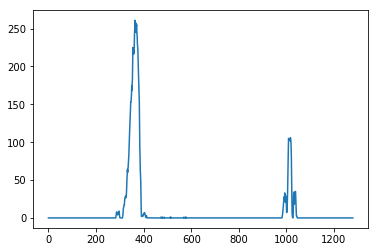

In [69]:

video_output = 'project_video_output.mp4'
process_image = PiplineProcess('camera_cal/calibration*.jpg')
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

In [70]:
video_output = 'project_video_output.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))